# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [2]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [3]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [4]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='12h'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

# Model Functions

In [5]:
def model_1(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [6]:
def model_2(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [7]:
def model_3(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

# Other Functions

In [8]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<11}'.format(round(float(last_price), 5)), 
                       'MyGamble: {:<11}'.format(round(float(my_gamble), 5)), 
                       'TruePrice: {:<11}'.format(round(float(true_price1), 5)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        if len(buy_list) != 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        if len(buy_list) == 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', '\n') 
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        if len(index) > 0: 
            print('Wrong Buy_Act List:')
            for i in index:
                print(symbols[i], '\n')

In [9]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [10]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [11]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate


Pred proft %: 1.000871283229492
Gamble proft %: 1.000001586675142
True proft %: 0.9897309684472976

Look Back: 11 / Total Loss: 4660185.621273627 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04719    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97917    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.8


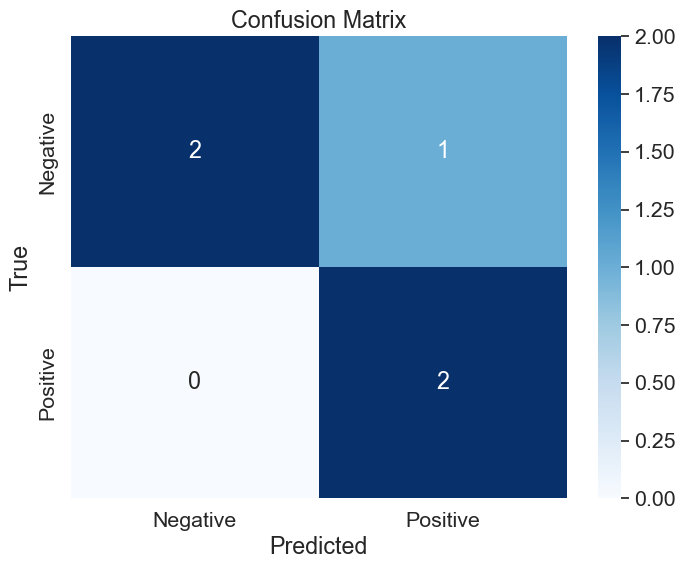

Wrong Buy_Act List:
ETHBRL 


Pred proft %: 1.00405656608047
Gamble proft %: 1.0030525095143894
True proft %: 1.0033837579617835

Look Back: 11 / Total Loss: 961830.4346347362 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03934    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.8


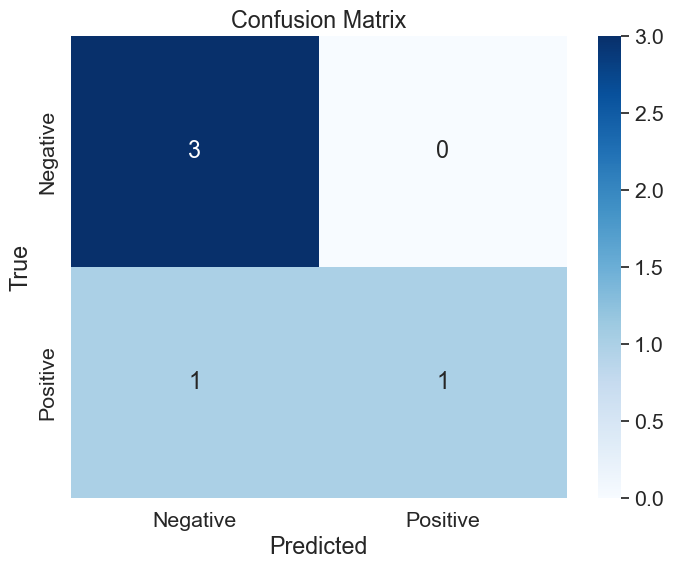


Pred proft %: 1.0022312238730449
Gamble proft %: 1.0012289926491718
True proft %: 1.0023011505752877

Look Back: 11 / Total Loss: 11177654.469439832 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.0327     ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


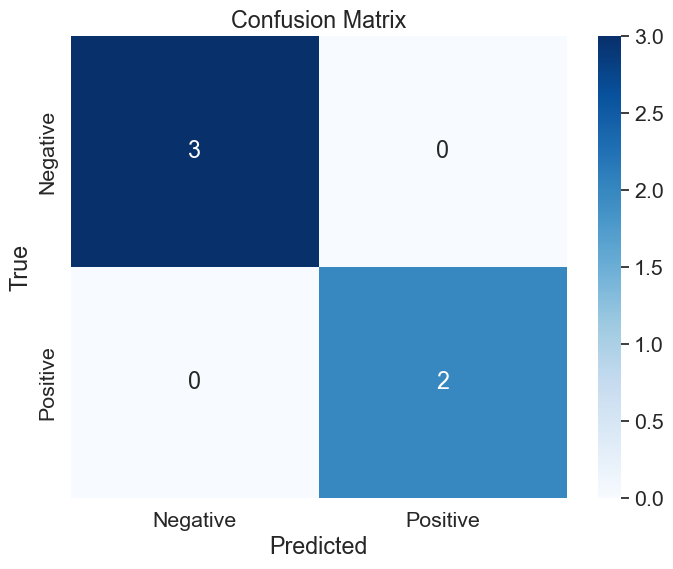

In [12]:
for i in range(3):
    pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols[:5], print_info = False)


All False

Look Back: 11 / Total Loss: 769097.581926012 / Sold Portion: 

CM accuracy: 0.6


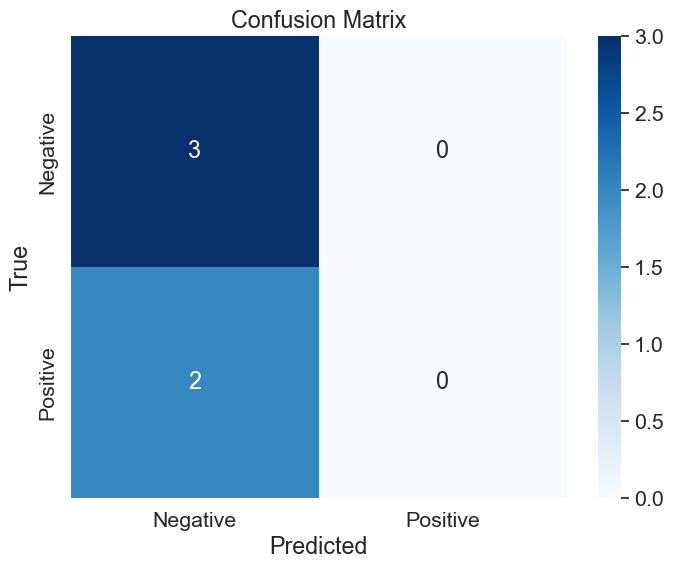


Pred proft %: 1.0090160901379432
Gamble proft %: 1.0080070740478055
True proft %: 1.0033837579617835

Look Back: 11 / Total Loss: 10950453.251145802 / Sold Portion: 0.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.06423    ', 'TruePrice: 5.041      ', 'GambleProft: 1.008', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.8


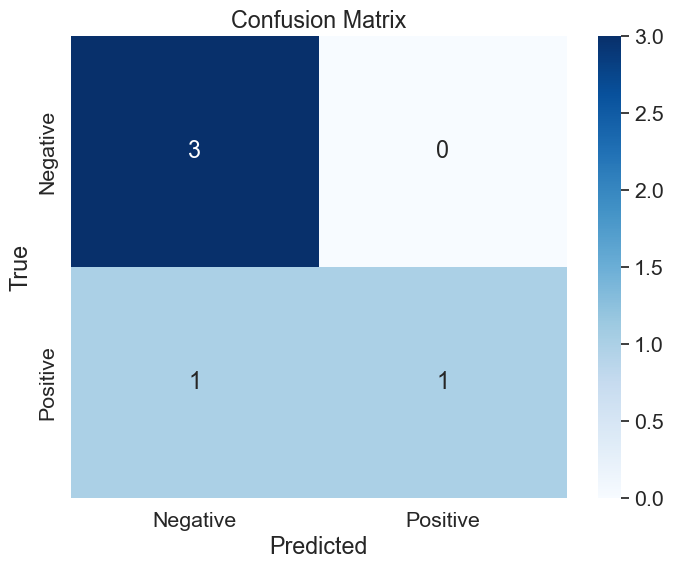


Pred proft %: 1.0049223601668997
Gamble proft %: 1.0042702623341546
True proft %: 1.0023011505752877

Look Back: 11 / Total Loss: 7412796.792926219 / Sold Portion: 0.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.06668    ', 'TruePrice: 5.041      ', 'GambleProft: 1.008', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 1.0


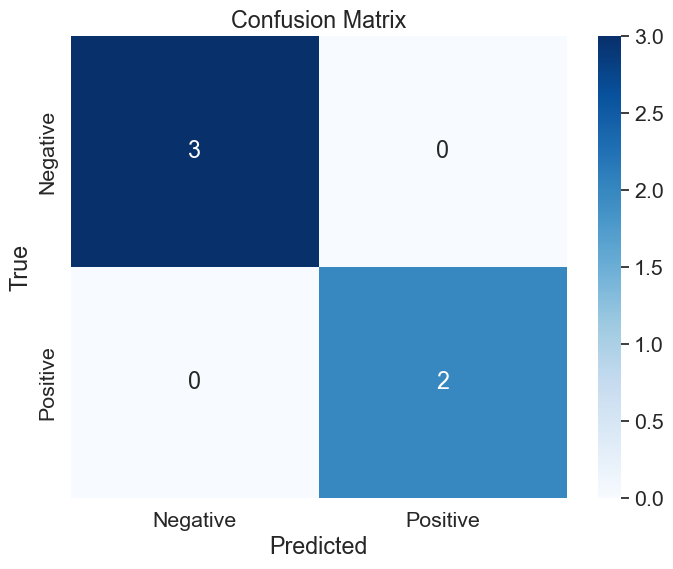

In [13]:
for i in range(3):
    pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols[:5], print_info = False)


Pred proft %: 1.0026655535867297
Gamble proft %: 1.0022547418442649
True proft %: 1.0023011505752877

Look Back: 11 / Total Loss: 2733731.0750481603 / Sold Portion: 0.0 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99354    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 1.0


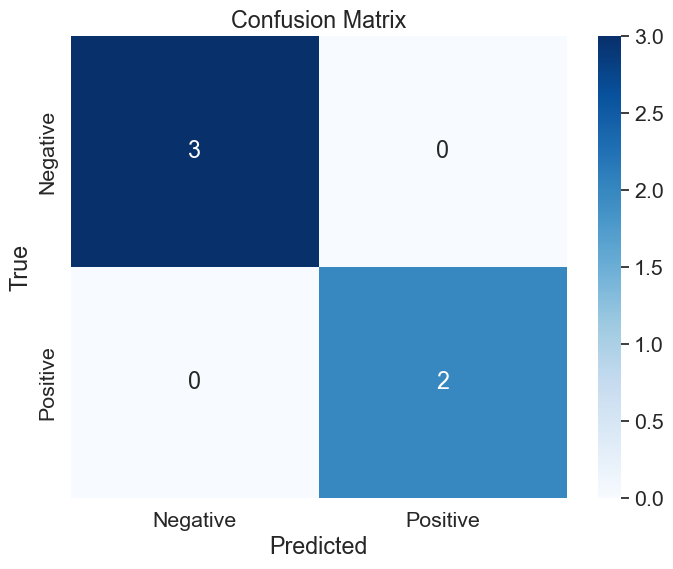


Pred proft %: 1.0048931154267318
Gamble proft %: 1.003888222311305
True proft %: 1.0023011505752877

Look Back: 11 / Total Loss: 383406349.77238595 / Sold Portion: 0.0 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00893    ', 'TruePrice: 4.977      ', 'GambleProft: 1.008', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 1.0


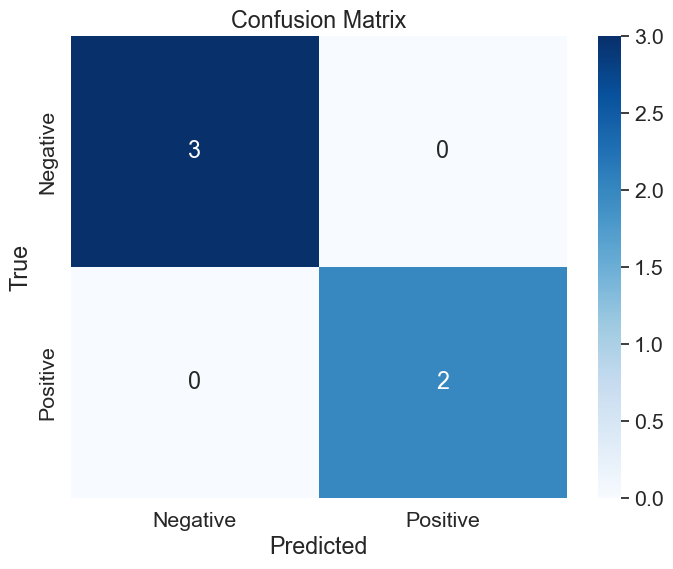


Pred proft %: 0.9997243342130049
Gamble proft %: 1.0
True proft %: 1.0023011505752877

Look Back: 11 / Total Loss: 1482068.4217724595 / Sold Portion: 

CM accuracy: 1.0


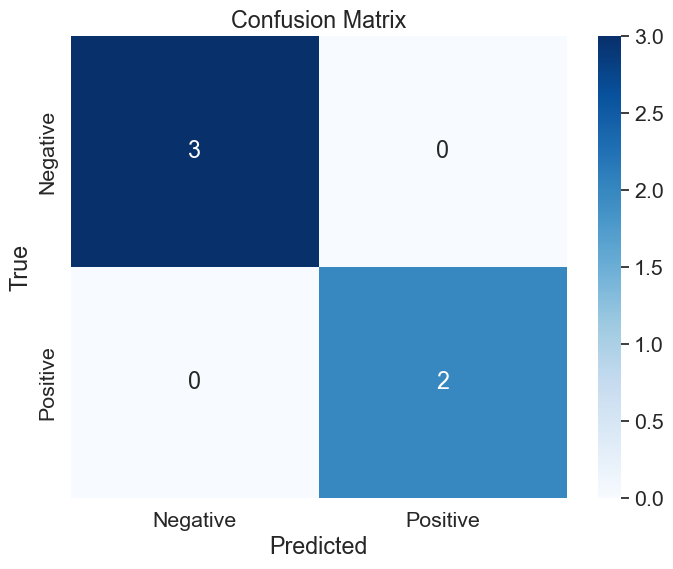

In [14]:
for i in range(3):
    pred_eval(model_3, epochs = 100, lb_list = [11], ticker_list = symbols[:5], print_info = False)


Pred proft %: 1.003742782571946
Gamble proft %: 1.0040540215190137
True proft %: 1.010961146351877

Look Back: 11 / Total Loss: 10119429.65840967 / Sold Portion: 0.6666666666666666 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.5576   ', 'TruePrice: 109.59     ', 'GambleProft: 1.007', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.15432    ', 'TruePrice: 6.194      ', 'GambleProft: 1.009', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 68.64149   ', 'TruePrice: 69.73      ', 'GambleProft: 1.028', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.2737    ', 'TruePrice: 38.75      ', 'GambleProft: 1.005', 'TrueProft: 1.017', 'SoldStatus:

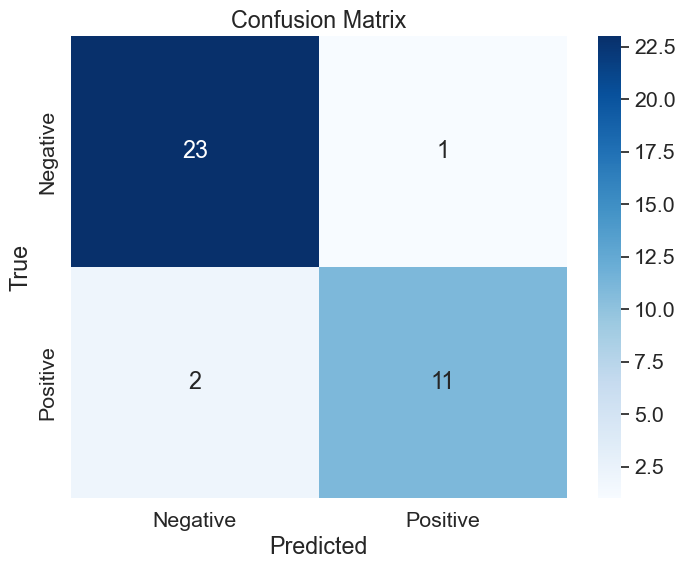

Wrong Buy_Act List:
SOLBRL 



In [15]:
for i in range(1):
    pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0096793897464025
Gamble proft %: 1.0096630872617542
True proft %: 1.0304932544580157

Look Back: 3 / Total Loss: 4902532.264331789 / Sold Portion: 0.8 

['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.63342   ', 'TruePrice: 69.73      ', 'GambleProft: 1.013', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.15665   ', 'TruePrice: 38.75      ', 'GambleProft: 1.001', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.81728   ', 'TruePrice: 19.78      ', 'GambleProft: 1.016', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.40743    ', 'TruePrice: 1.337      ', 'GambleProft: 1.069', 'TrueProft: 1.015', 'SoldStatus: 0', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.43456    ', 'TruePrice: 8.72       ', 'GambleProft: 1.008', 'TrueProft: 1.042', 'SoldStatus: 1', 'Correct

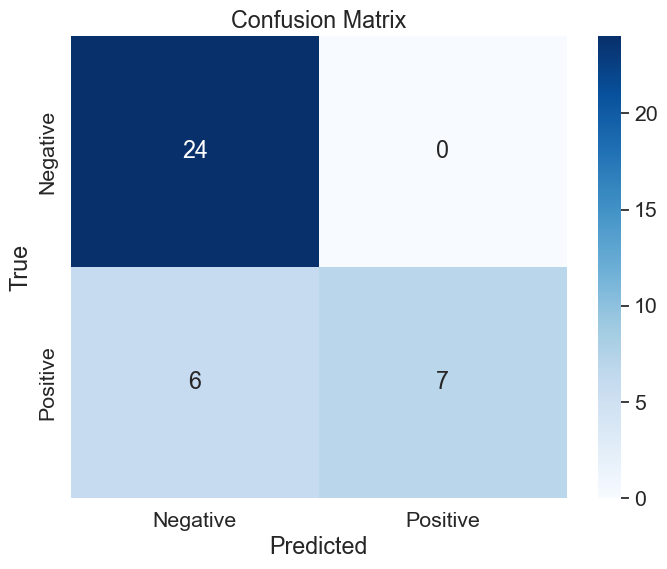

In [16]:
for i in range(1):
    pred_eval(model_1, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)


Pred proft %: 1.0127440845108204
Gamble proft %: 1.0119008070892463
True proft %: 1.0111689014150624

Look Back: 3 / Total Loss: 453312.1811685238 / Sold Portion: 0.6 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03354    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.87178    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.003', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['SOLBRL  ', 'LastPrice: 730.9      ', 'MyGamble: 741.23751  ', 'TruePrice: 727.7      ', 'GambleProft: 1.014', 'TrueProft: 0.996', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.70481   ', 'TruePrice: 69.73      ', 'GambleProft: 1.014', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.45816   ', 'TruePrice: 38.75      ', 'GambleProft: 1.009', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectM

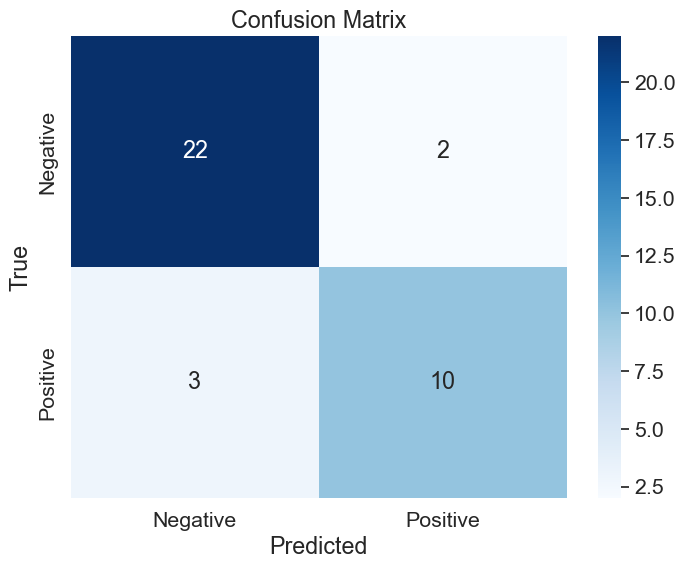

Wrong Buy_Act List:
DOGEBRL 

SOLBRL 



In [19]:
for i in range(1):
    pred_eval(model_1, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)


Pred proft %: 1.0052569102807491
Gamble proft %: 1.0056141013937776
True proft %: 1.0514906027429063

Look Back: 1 / Total Loss: 7239406.383497383 / Sold Portion: 0.8 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.06141    ', 'TruePrice: 5.041      ', 'GambleProft: 1.007', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.52373  ', 'TruePrice: 109.59     ', 'GambleProft: 1.007', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01463    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.011', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.01699   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.46876   ', 'TruePrice: 38.75      ', 'GambleProft: 1.01 ', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectM

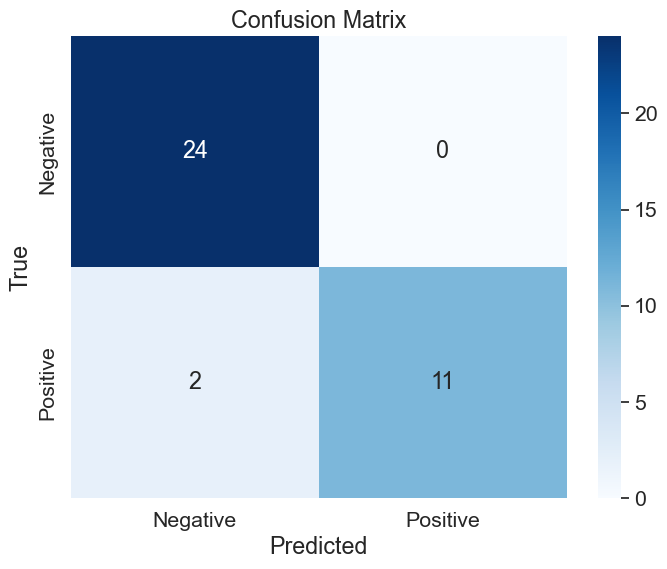

In [17]:
for i in range(1):
    pred_eval(model_1, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)


Pred proft %: 1.0062638520703315
Gamble proft %: 1.0063786626417455
True proft %: 1.0511101763171202

Look Back: 1 / Total Loss: 1295793.677613147 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04007    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.59121  ', 'TruePrice: 109.59     ', 'GambleProft: 1.008', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01467    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.013', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.8763    ', 'TruePrice: 69.73      ', 'GambleProft: 1.001', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.46841   ', 'TruePrice: 38.75      ', 'GambleProft: 1.01 ', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectM

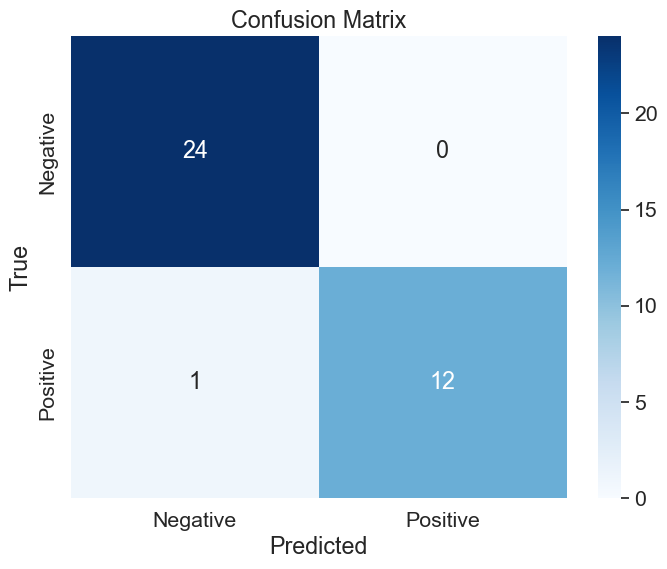

In [18]:
for i in range(1):
    pred_eval(model_1, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)


Pred proft %: 1.006098143423037
Gamble proft %: 1.0062008890522744
True proft %: 1.050357984680359

Look Back: 1 / Total Loss: 4205200.375671659 / Sold Portion: 0.7 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04386    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00381    ', 'TruePrice: 4.977      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.14024  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94173   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectMod

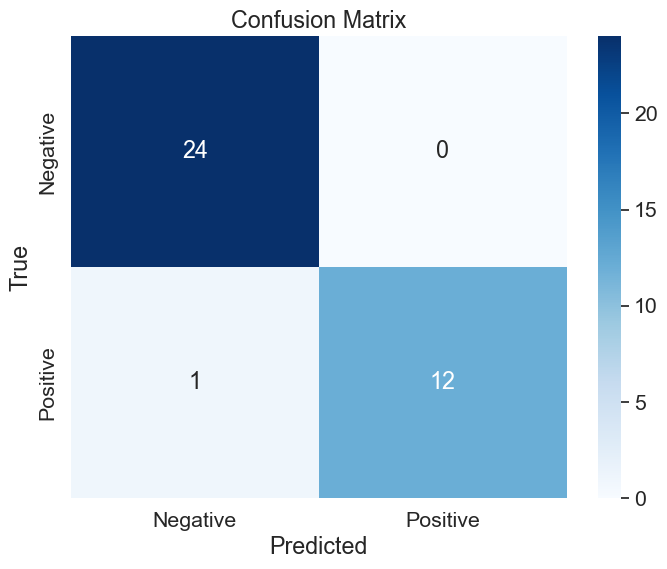


Pred proft %: 1.005134478801431
Gamble proft %: 1.0056395768645847
True proft %: 1.0177540134712468

Look Back: 3 / Total Loss: 12151212.047626182 / Sold Portion: 0.75 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04386    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00381    ', 'TruePrice: 4.977      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.14024  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94173   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'Correct

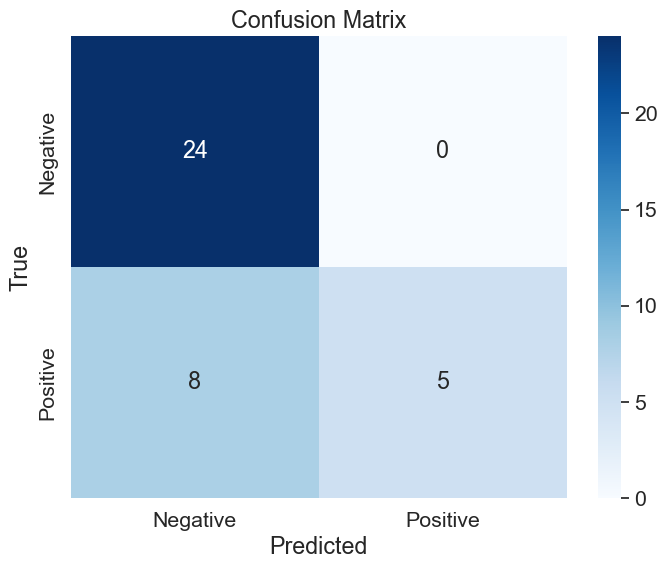

0:08:20.746320


In [20]:
for i in range(1):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 100, lb_list = [1,3], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0167638326371293
Gamble proft %: 1.0159161730538602
True proft %: 1.0380806669066627

Look Back: 3 / Total Loss: 666879.0670381858 / Sold Portion: 0.375 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.78432  ', 'TruePrice: 109.59     ', 'GambleProft: 1.019', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.40708   ', 'TruePrice: 38.75      ', 'GambleProft: 1.008', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88812    ', 'TruePrice: 1.923      ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.84504   ', 'TruePrice: 19.78      ', 'GambleProft: 1.017', 'TrueProft: 1.014', 'SoldStatus: 0', 'CorrectModel: 1']
['SANDBRL ', 'LastPrice: 1.829      ', 'MyGamble: 3.39049    ', 'TruePrice: 1.785      ', 'GambleProft: 1.854', 'TrueProft: 0.976', 'SoldStatus: 0', 'Corre

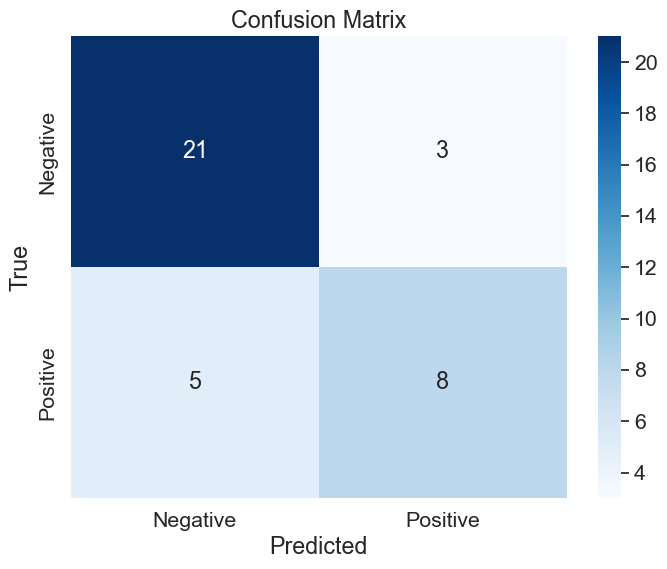

Wrong Buy_Act List:
SANDBRL 

LUNABRL 

ATOMBRL 

0:04:32.614390


In [21]:
for i in range(1):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0031955234668075
Gamble proft %: 1.0040154797631335
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 10156057.470642233 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04833    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00465    ', 'TruePrice: 4.977      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.22306  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


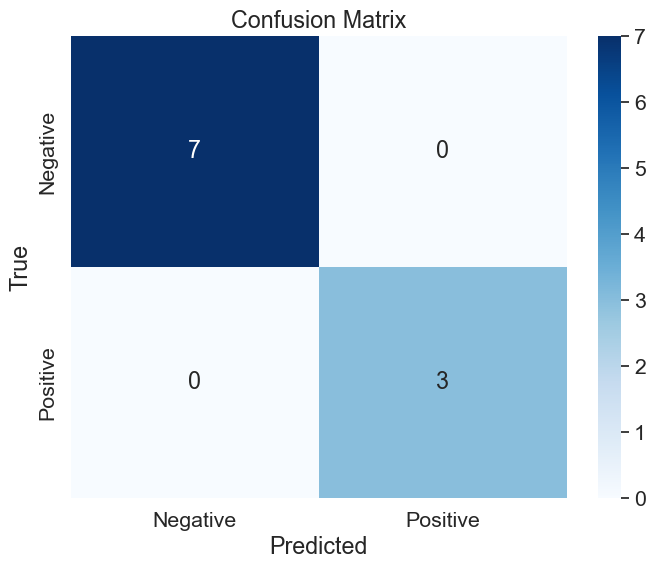

0:00:52.864643

Pred proft %: 1.0005753481073882
Gamble proft %: 1.0004371739271727
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 4005155.325298002 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04573    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99728    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 1.0


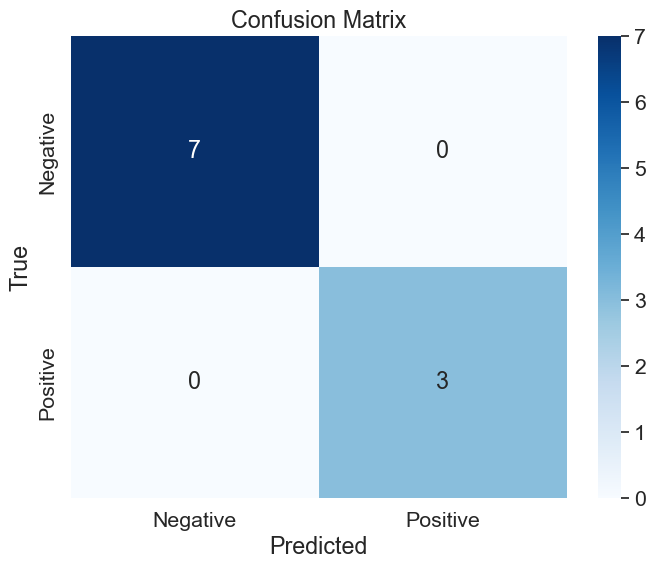

0:00:54.525825

Pred proft %: 0.9984279810912879
Gamble proft %: 1.0002265579130551
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 7786134.559785029 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03994    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97995    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


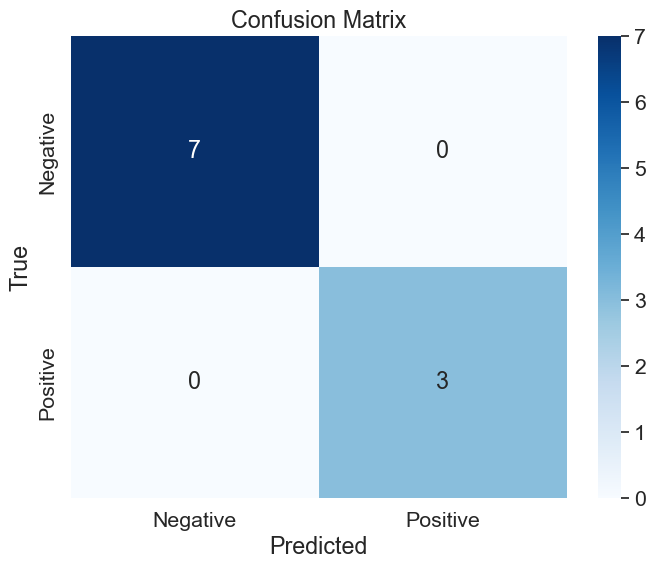

0:00:55.541192

Pred proft %: 1.0030218676528309
Gamble proft %: 1.0038417165604014
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 5374962.817267804 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03326    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.01608    ', 'TruePrice: 4.977      ', 'GambleProft: 1.009', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.20761  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


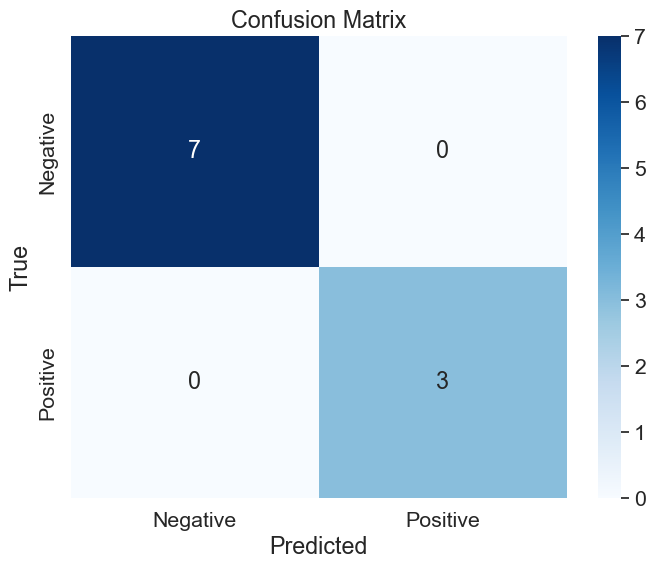

0:00:54.290614

Pred proft %: 1.002785265947683
Gamble proft %: 1.003605316725796
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 3533348.590999586 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03122    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99407    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.2057   ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


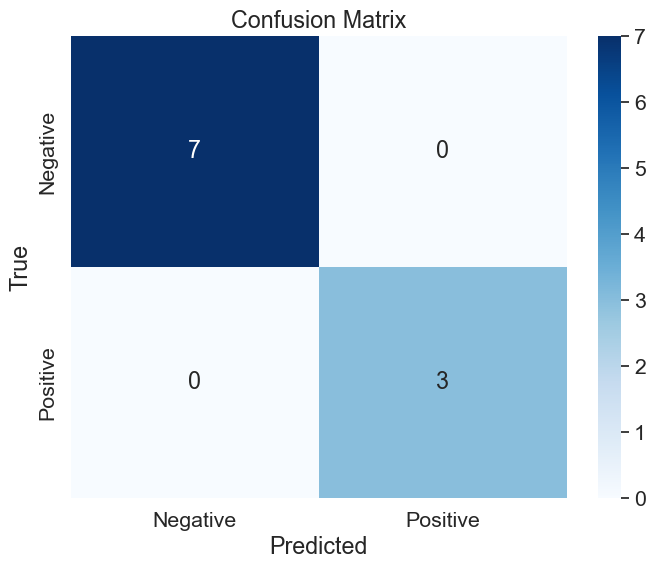

0:00:56.577301

Pred proft %: 1.0080746855361273
Gamble proft %: 1.0070666108505912
True proft %: 1.0023011505752877

Look Back: 1 / Total Loss: 9014571.903967703 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03911    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.02652    ', 'TruePrice: 4.977      ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.9


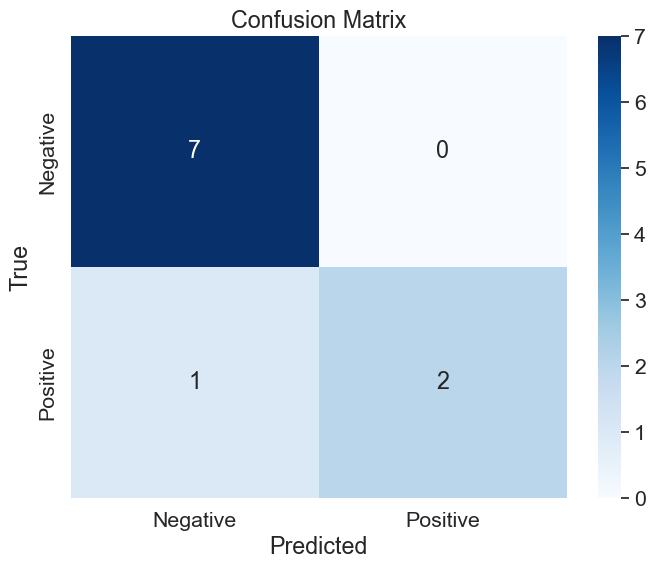

0:00:59.354083

Pred proft %: 0.9985189540450952
Gamble proft %: 1.0000810940654168
True proft %: 1.0931396856881292

Look Back: 1 / Total Loss: 4588917.512248742 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.0325     ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.9


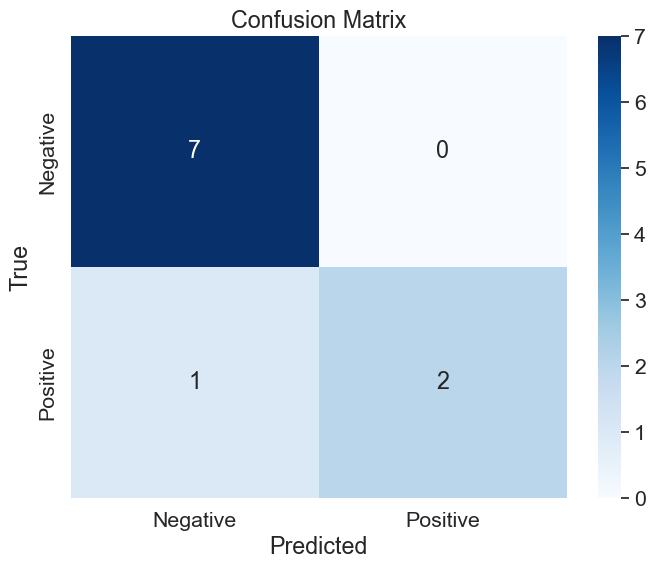

0:00:55.830118

Pred proft %: 1.0011476180862828
Gamble proft %: 1.0002241946256563
True proft %: 1.0024364755462105

Look Back: 1 / Total Loss: 9406479.449249173 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03428    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.9928     ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.9


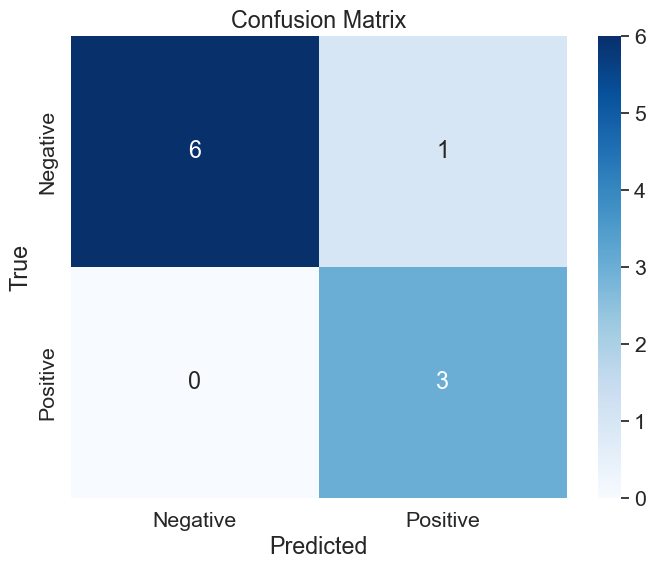

Wrong Buy_Act List:
BNBBRL 

0:00:56.743105

Pred proft %: 1.014319276725035
Gamble proft %: 1.0151505896383832
True proft %: 1.0889789229298492

Look Back: 1 / Total Loss: 9300389.207929412 / Sold Portion: 0.5 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.01131    ', 'TruePrice: 4.977      ', 'GambleProft: 1.008', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.45886  ', 'TruePrice: 109.59     ', 'GambleProft: 1.016', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


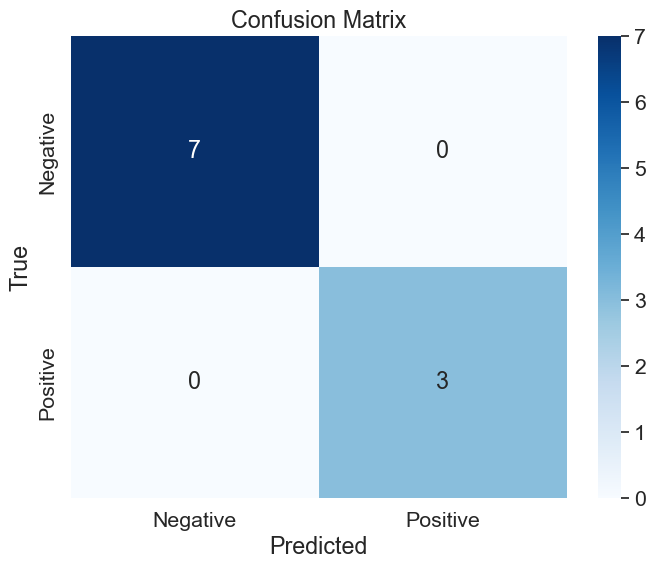

0:00:57.962152

Pred proft %: 1.0061922402546488
Gamble proft %: 1.0051860480143942
True proft %: 1.0023011505752877

Look Back: 1 / Total Loss: 3881245.4408136555 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04809    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99874    ', 'TruePrice: 4.977      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.9


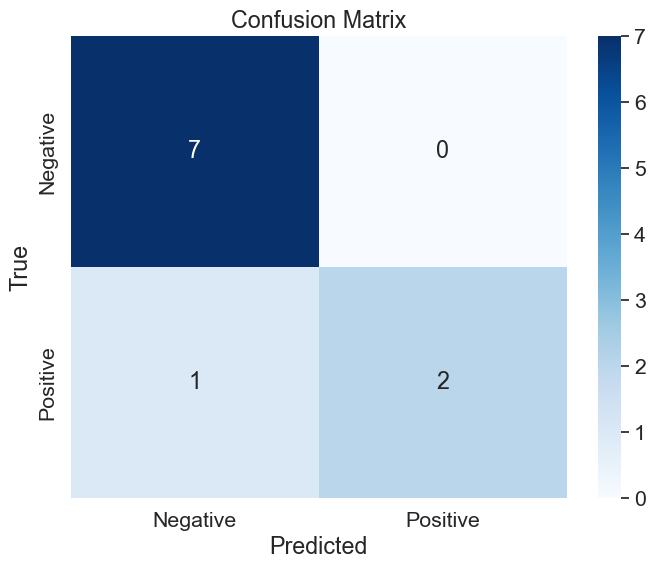

0:00:56.650851


In [22]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 50, lb_list = [1], ticker_list = symbols[:10], print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0025354852546258
Gamble proft %: 1.0024947470736614
True proft %: 1.0023427790454649

Look Back: 1 / Total Loss: 6192778.395259059 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04868    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.9333333333333333


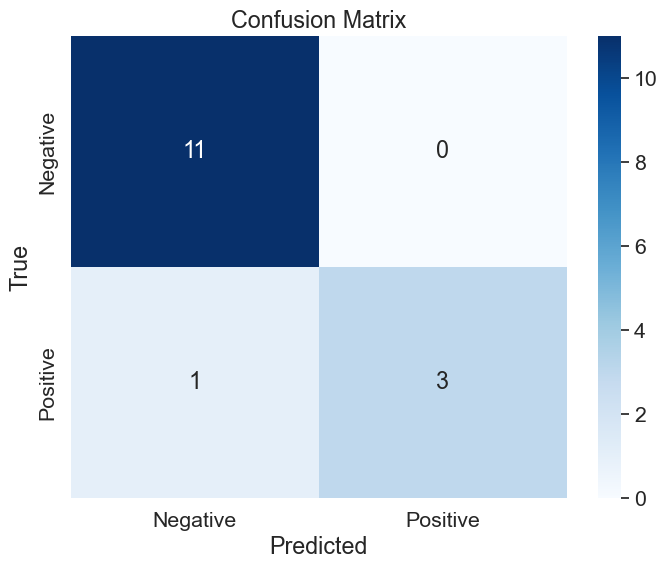

0:01:56.613667

Pred proft %: 0.9998529746380502
Gamble proft %: 1.0002357132479707
True proft %: 1.0889712905331914

Look Back: 1 / Total Loss: 6597845.111335306 / Sold Portion: 0.5 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99275    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01476    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.019', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 1.0


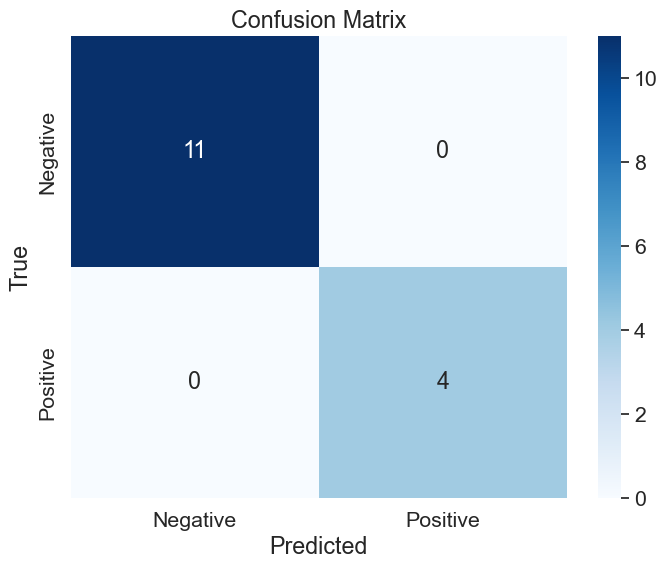

0:01:36.404740


In [23]:
for i in range(2):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 80, lb_list = [1], ticker_list = symbols[:15], print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0078083875486092
Gamble proft %: 1.0068005846691779
True proft %: 0.9988893509436393

Look Back: 1 / Total Loss: 39470142.87373274 / Sold Portion: 0.75 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04274    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2688.20144 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.007', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97616    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01476    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.019', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.8666666666666667


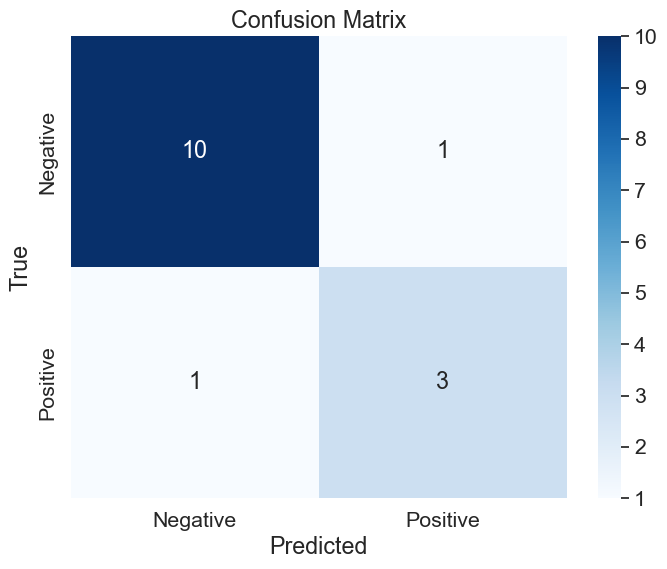

Wrong Buy_Act List:
BNBBRL 

0:02:40.342897

Pred proft %: 1.0004458248080164
Gamble proft %: 1.000370068391321
True proft %: 1.0023427790454649

Look Back: 1 / Total Loss: 3564879.7903153 / Sold Portion: 

CM accuracy: 0.9333333333333333


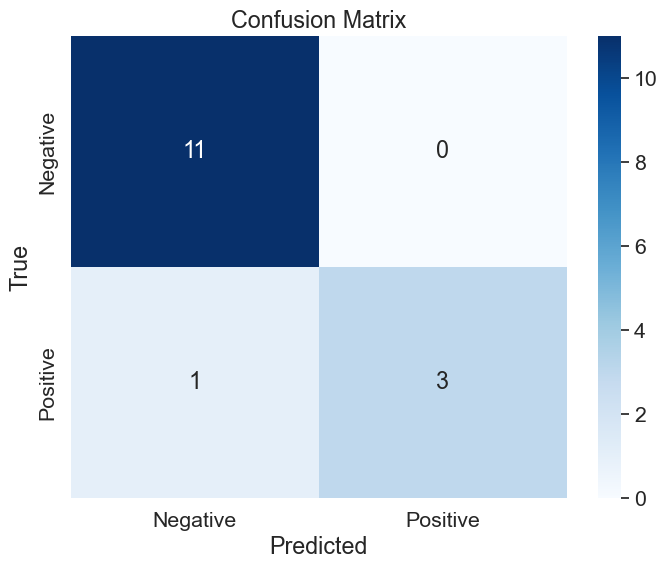

0:02:40.282925


In [25]:
for i in range(2):
    d = dt.datetime.now()
    pred_eval(model_2, epochs = 100, lb_list = [1], ticker_list = symbols[:15], print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0018535029671538
Gamble proft %: 1.0008464371300603
True proft %: 1.0023427790454649

Look Back: 3 / Total Loss: 6134720.380124871 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03095    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.9333333333333333


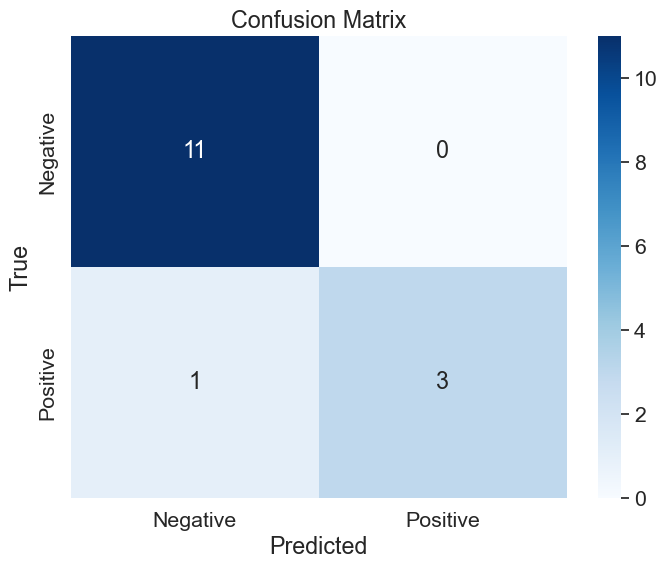

0:03:10.381233

Pred proft %: 1.0150108211074305
Gamble proft %: 1.0158282693156717
True proft %: 1.088161726639082

Look Back: 3 / Total Loss: 3079836.1928272294 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.06068    ', 'TruePrice: 5.041      ', 'GambleProft: 1.007', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.53778  ', 'TruePrice: 109.59     ', 'GambleProft: 1.017', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.88353    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.016', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01475    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.019', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.9333333333333333


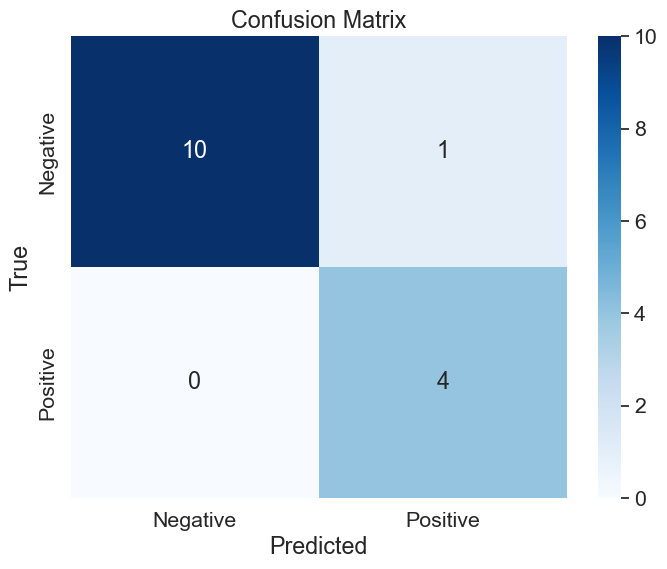

Wrong Buy_Act List:
DOGEBRL 

0:03:15.986075


In [26]:
for i in range(2):
    d = dt.datetime.now()
    pred_eval(model_2, epochs = 100, lb_list = [3], ticker_list = symbols[:15], print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0087804596181587
Gamble proft %: 1.0071520534143927
True proft %: 1.0261252275423045

Look Back: 1 / Total Loss: 2663333.544193812 / Sold Portion: 0.7272727272727273 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.06349    ', 'TruePrice: 5.041      ', 'GambleProft: 1.008', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98189    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.02136    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.475', 'TrueProft: 1.031', 'SoldStatus: 0', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94637   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus

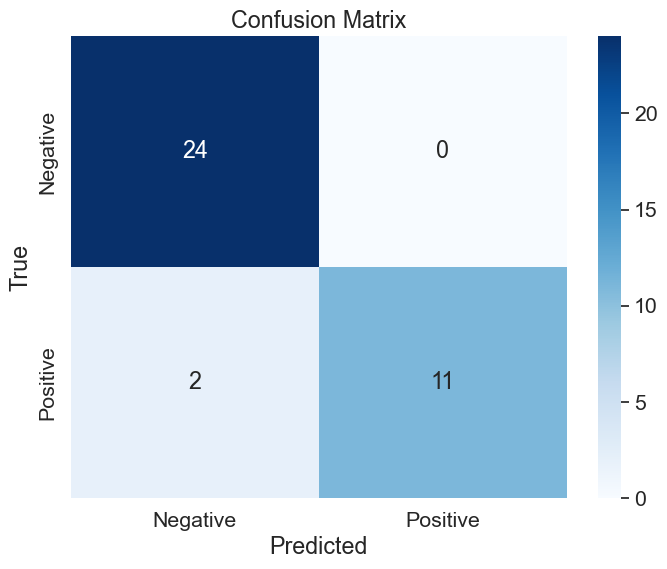

0:03:24.525231

Pred proft %: 1.0067672524392477
Gamble proft %: 1.005983475929204
True proft %: 1.0257738855376684

Look Back: 1 / Total Loss: 5381800.25037363 / Sold Portion: 0.7272727272727273 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03003    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99338    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.1125     ', 'TruePrice: 6.194      ', 'GambleProft: 1.002', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.99632   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.28966   ', 'TruePrice: 38.75      ', 'GambleProft: 1.005', 'TrueProft: 1.017'

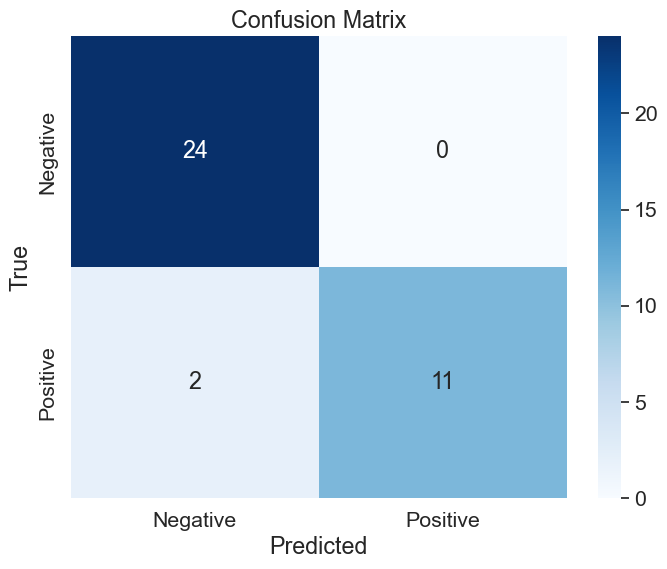

0:03:21.335686

Pred proft %: 1.0115908245803673
Gamble proft %: 1.009900562029721
True proft %: 1.0257738855376684

Look Back: 1 / Total Loss: 6185688.909948134 / Sold Portion: 0.6363636363636364 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.05471    ', 'TruePrice: 5.041      ', 'GambleProft: 1.006', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00206    ', 'TruePrice: 4.977      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14201    ', 'TruePrice: 6.194      ', 'GambleProft: 1.007', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.04301   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017

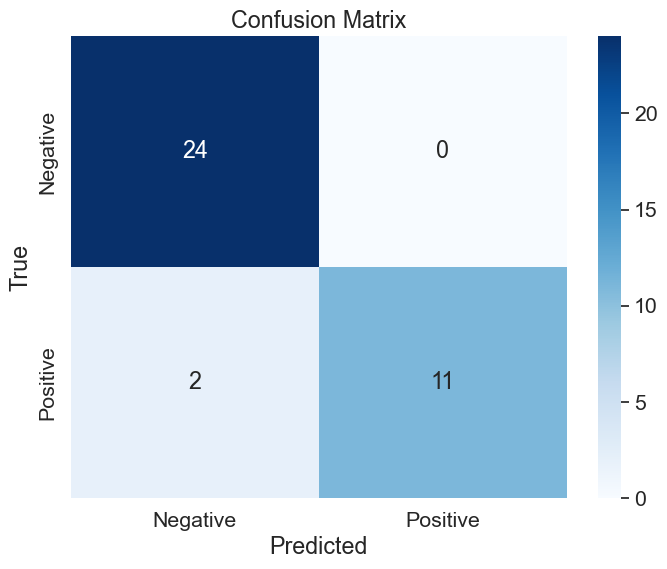

0:03:02.503399

Pred proft %: 1.006286594276549
Gamble proft %: 1.0061668347275976
True proft %: 1.0500697154851566

Look Back: 1 / Total Loss: 13456667.434038902 / Sold Portion: 0.9090909090909091 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.047      ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97912    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7659     ', 'MyGamble: 1.04564    ', 'TruePrice: 0.7561     ', 'GambleProft: 1.365', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.12805    ', 'TruePrice: 6.194      ', 'GambleProft: 1.004', 'TrueProft: 1.01

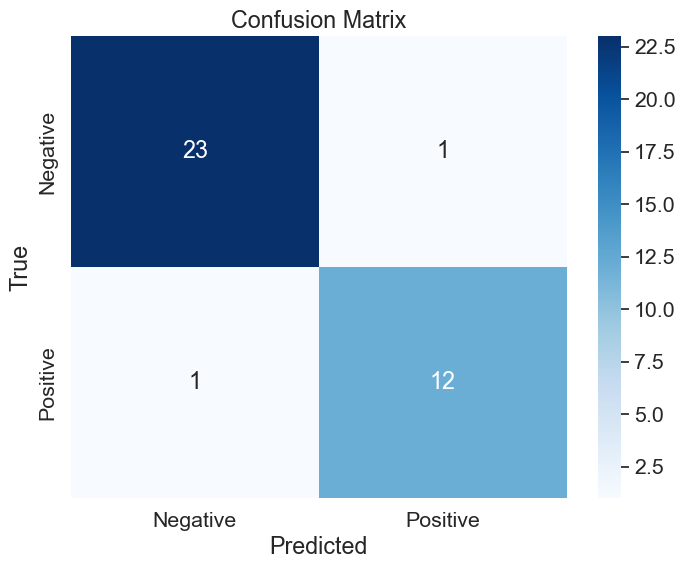

Wrong Buy_Act List:
CHZBRL 

0:03:19.967177

Pred proft %: 1.0079678328693473
Gamble proft %: 1.0074417905867001
True proft %: 1.050502371668673

Look Back: 1 / Total Loss: 937524.0468573465 / Sold Portion: 0.6666666666666666 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99089    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.14125  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.69251   ', 'TruePrice: 19.78      ', 'GamblePr

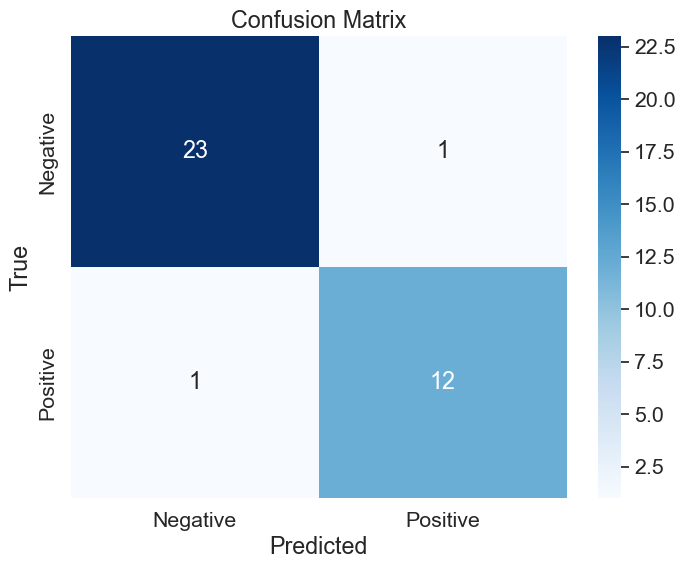

Wrong Buy_Act List:
LUNABRL 

0:03:22.313912

Pred proft %: 1.0032762769899675
Gamble proft %: 1.0038645497745025
True proft %: 1.0503570283768215

Look Back: 1 / Total Loss: 6539325.327631291 / Sold Portion: 0.9 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.01339    ', 'TruePrice: 4.977      ', 'GambleProft: 1.009', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01452    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.003', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.97215   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.58007   ', 'TruePrice: 38.75      ', 'GambleProft: 1.013', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90221    ', 'TruePrice: 1.923      ', 'GambleProft: 1.017', '

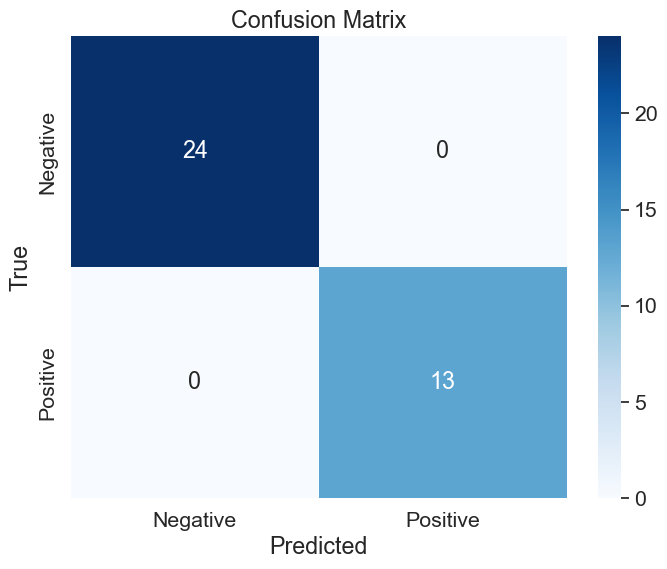

0:03:23.288024

Pred proft %: 1.005794186870715
Gamble proft %: 1.0048404376106104
True proft %: 1.0006630407880455

Look Back: 1 / Total Loss: 471474.845585785 / Sold Portion: 0.8181818181818182 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03103    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2682.98206 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.005', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.9944     ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14811    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015'

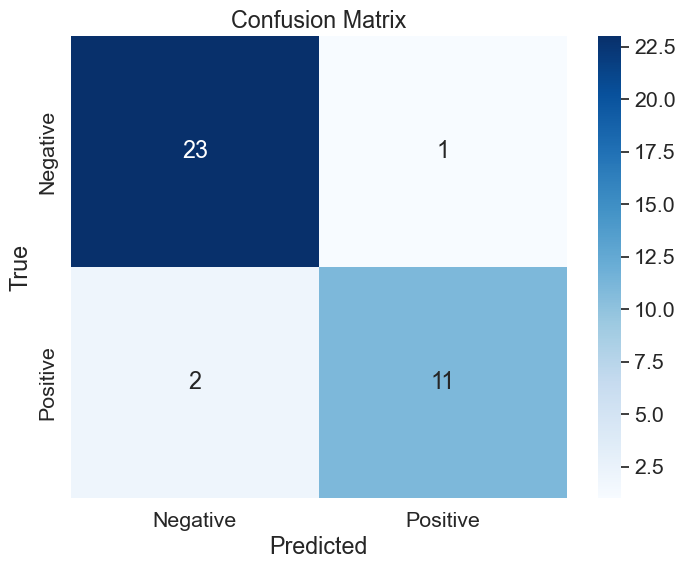

Wrong Buy_Act List:
BNBBRL 

0:03:23.564671

Pred proft %: 1.0083637039630886
Gamble proft %: 1.0077194751444942
True proft %: 1.0502357525422092

Look Back: 1 / Total Loss: 22376909.129026234 / Sold Portion: 0.6 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98383    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.38406  ', 'TruePrice: 109.59     ', 'GambleProft: 1.005', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00022    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.268', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.89253   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', '

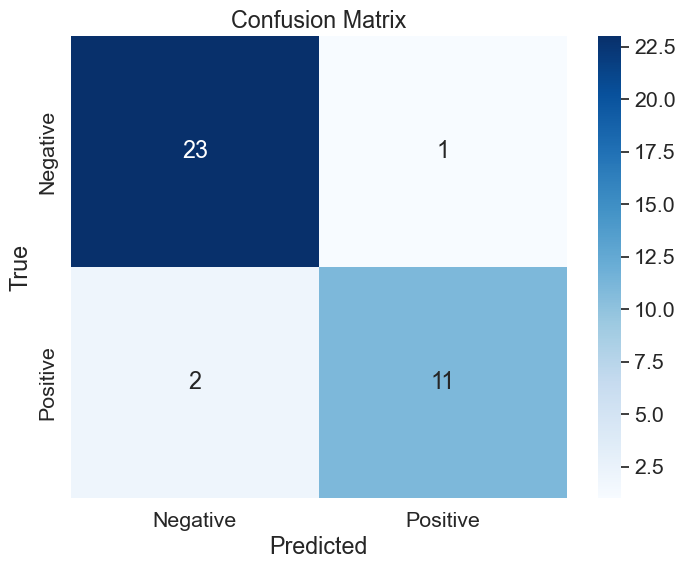

Wrong Buy_Act List:
SHIBBRL 

0:03:21.821459

Pred proft %: 1.0053758096988863
Gamble proft %: 1.0061138456411998
True proft %: 1.0556017100161634

Look Back: 1 / Total Loss: 3531197.67904919 / Sold Portion: 0.875 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97793    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01453    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.004', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.89413   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.72371   ', 'TruePrice: 38.75      ', 'GambleProft: 1.016', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.63217   ', 'TruePrice: 19.78      ', 'GambleProft: 1.006',

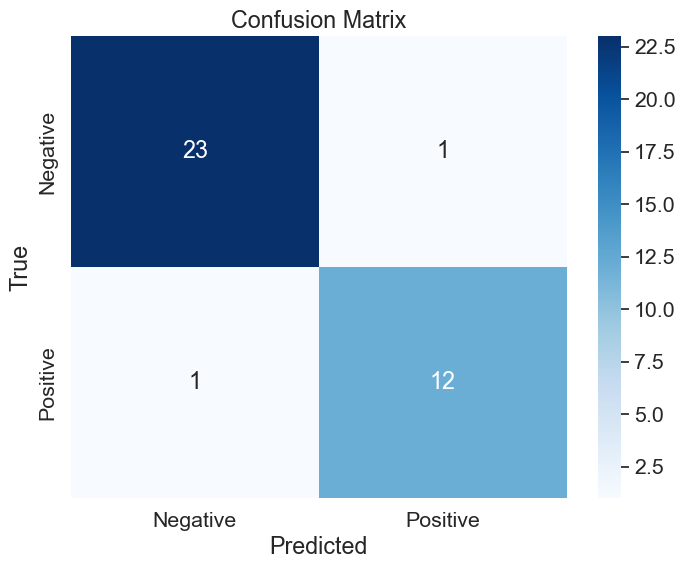

Wrong Buy_Act List:
LUNABRL 

0:03:23.164222

Pred proft %: 1.0056809651625407
Gamble proft %: 1.0047557319131528
True proft %: 1.0006320862382745

Look Back: 1 / Total Loss: 5860301.484668832 / Sold Portion: 0.8888888888888888 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03387    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2682.3811  ', 'TruePrice: 2667.0     ', 'GambleProft: 1.005', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98659    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.99466   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.7385    ', 'TruePrice: 38.75      ', 'GambleP

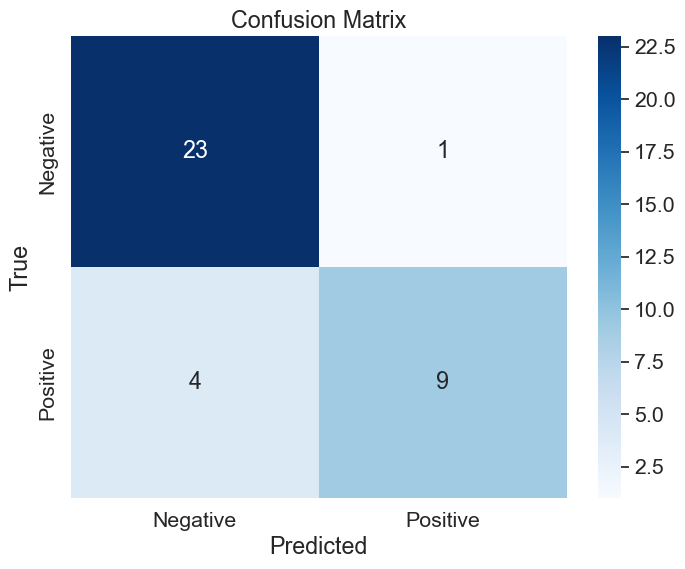

Wrong Buy_Act List:
BNBBRL 

0:03:23.057121


In [28]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0078549476001921
Gamble proft %: 1.007462562893844
True proft %: 1.0168810833562627

Look Back: 3 / Total Loss: 3207549.761499866 / Sold Portion: 0.875 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04403    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01459    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.007', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.72524   ', 'TruePrice: 69.73      ', 'GambleProft: 1.014', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.31165   ', 'TruePrice: 38.75      ', 'GambleProft: 1.006', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.55255   ', 'TruePrice: 19.78      ', 'GambleProft: 1.002', 'TrueProft: 1.014', 'SoldStatus: 1', 'Correc

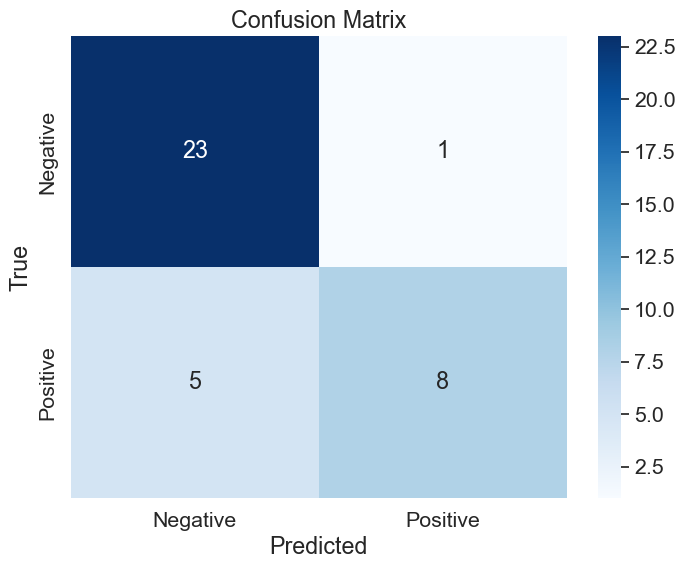

Wrong Buy_Act List:
ATOMBRL 

0:03:50.131515

Pred proft %: 1.0082803567031156
Gamble proft %: 1.008708797099364
True proft %: 1.061110662521344

Look Back: 3 / Total Loss: 3113097.053977832 / Sold Portion: 0.7777777777777778 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.29359  ', 'TruePrice: 109.59     ', 'GambleProft: 1.005', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.05527    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.378', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14792    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.53857   ', 'TruePrice: 69.73      ', 'GamblePro

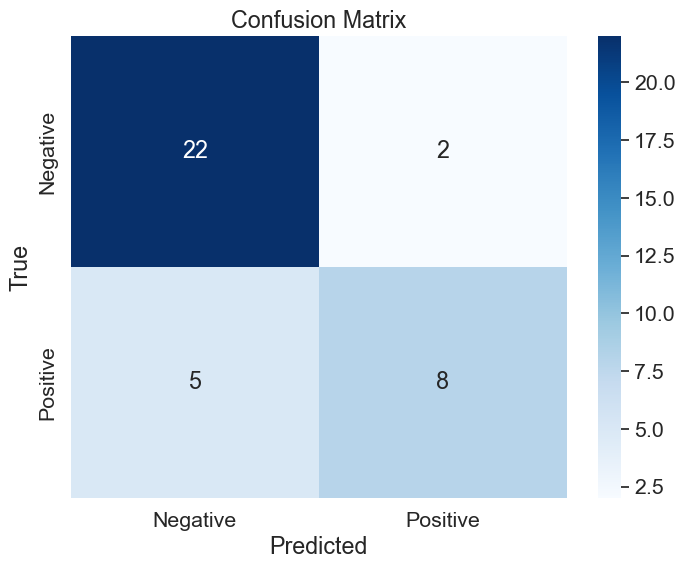

Wrong Buy_Act List:
HOTBRL 

FISBRL 

0:03:48.693819

Pred proft %: 1.0095176884681238
Gamble proft %: 1.0090641154680215
True proft %: 1.0258862057381943

Look Back: 3 / Total Loss: 14604329.944135891 / Sold Portion: 0.8888888888888888 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04184    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01452    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.002', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.9606    ', 'TruePrice: 69.73      ', 'GambleProft: 1.018', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.26538   ', 'TruePrice: 38.75      ', 'GambleProft: 1.004', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.87623    ', 'TruePrice: 1.923      ',

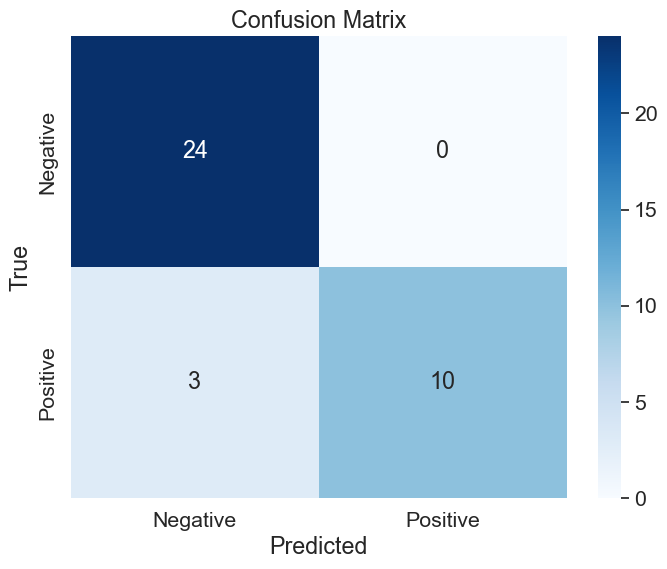

0:03:48.848628

Pred proft %: 1.0066071589801697
Gamble proft %: 1.0059886660550563
True proft %: 1.0165644619648178

Look Back: 3 / Total Loss: 2712203.6243628333 / Sold Portion: 0.8333333333333334 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03261    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98556    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00119    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.207', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.02664   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.0

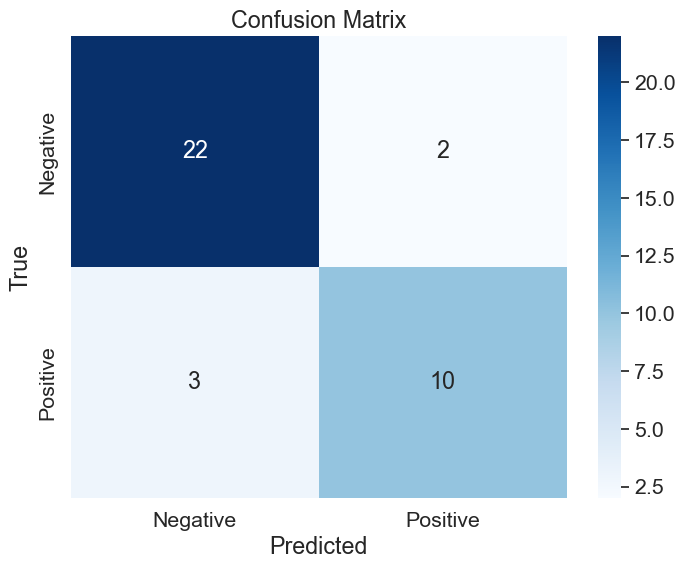

Wrong Buy_Act List:
WINBRL 

ATOMBRL 

0:03:46.464307

Pred proft %: 1.0074108618692064
Gamble proft %: 1.0079928952991966
True proft %: 1.0742347449495089

Look Back: 3 / Total Loss: 20158233.677901987 / Sold Portion: 0.7777777777777778 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04246    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99828    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.69983  ', 'TruePrice: 109.59     ', 'GambleProft: 1.009', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01453    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.003', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.05229    ', 'TruePrice: 0.0386     '

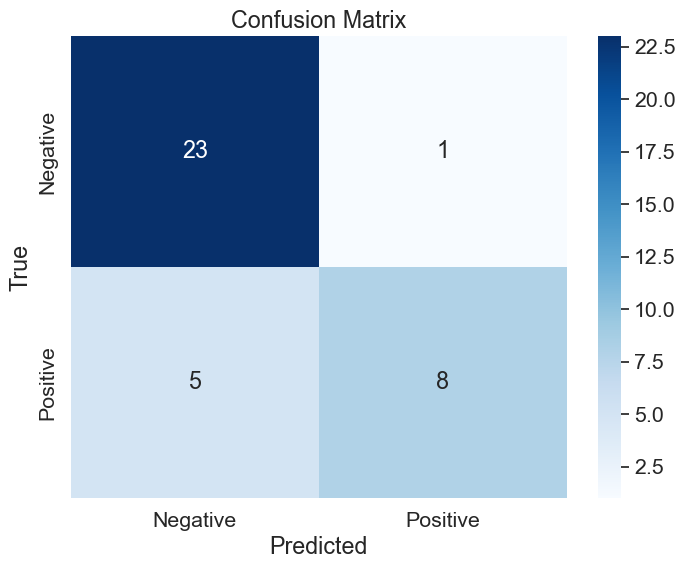

Wrong Buy_Act List:
HOTBRL 

0:03:48.484320

Pred proft %: 1.0054593662847215
Gamble proft %: 1.005936564377527
True proft %: 1.039483962777761

Look Back: 3 / Total Loss: 8493863.531753987 / Sold Portion: 0.7 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04456    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.04116    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.026', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00018    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.079', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.81328   ', 'TruePrice: 69.73      ', 'GambleProft: 1.015', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.36069   ', 'TruePrice: 38.75      ', 'GambleProft: 1.007', 'Tru

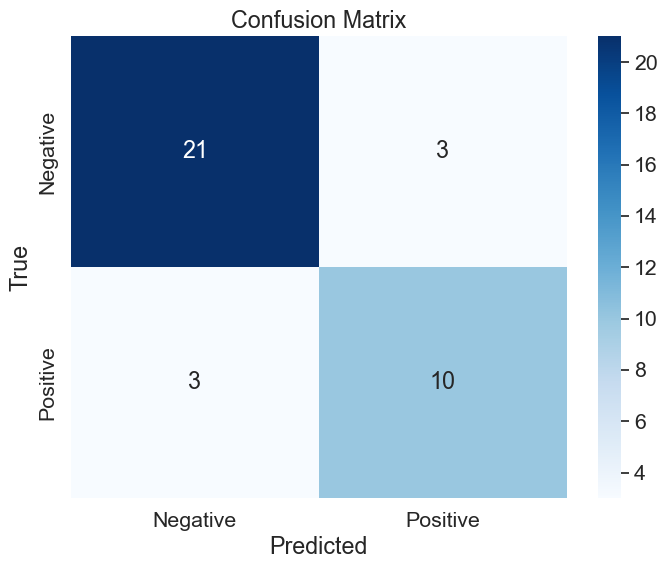

Wrong Buy_Act List:
HOTBRL 

SHIBBRL 

ATOMBRL 

0:03:47.964213

Pred proft %: 1.0051268592777942
Gamble proft %: 1.0048271266841378
True proft %: 1.0631095464391371

Look Back: 3 / Total Loss: 2053007.4656734152 / Sold Portion: 0.8888888888888888 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.24345  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01467    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.013', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.0406     ', 'TruePrice: 0.0386     ', 'GambleProft: 1.012', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.15595    ', 'TruePrice: 6.194      ', 'GambleProft: 1.009', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.12379   ', 'TruePrice: 69

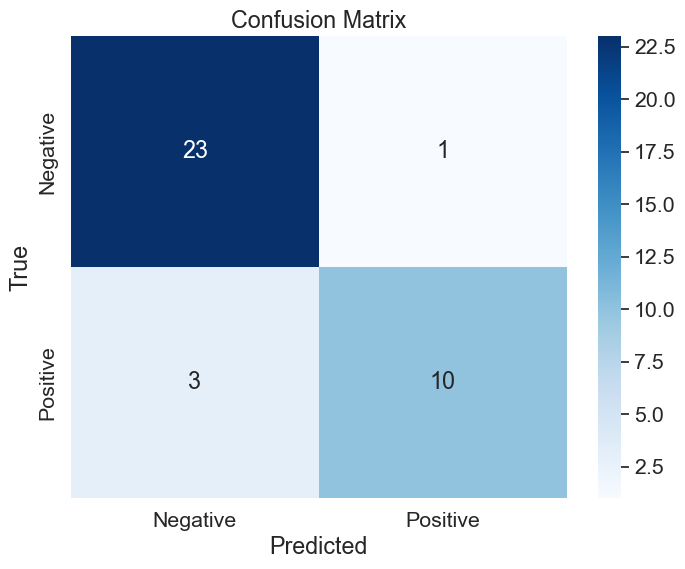

Wrong Buy_Act List:
HOTBRL 

0:03:47.680168

Pred proft %: 0.9987889436758903
Gamble proft %: 1.0000058725297523
True proft %: 0.9944333182930941

Look Back: 3 / Total Loss: 12207717.226273706 / Sold Portion: 0.7142857142857143 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98831    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.93266  ', 'TruePrice: 109.59     ', 'GambleProft: 1.011', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.05619    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.401', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.35182   ', 'TruePrice: 69.73      ', 'GambleProft: 1.008', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88366    ', 'TruePrice: 1.923      ', 'GambleP

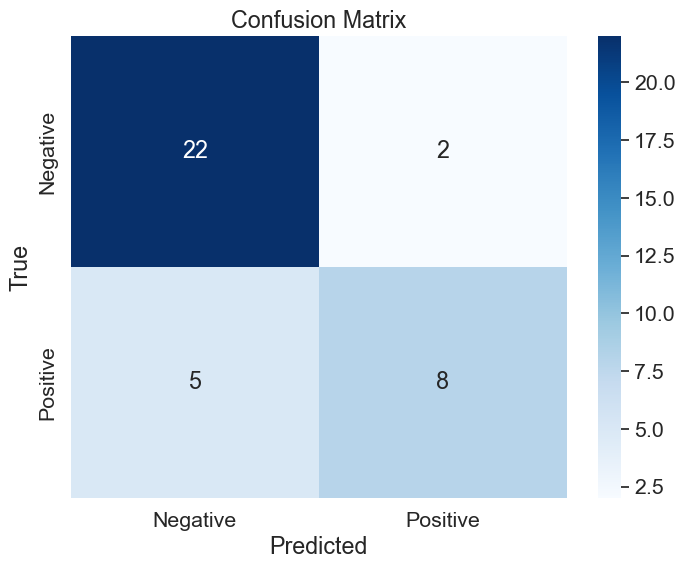

Wrong Buy_Act List:
BTCBRL 

HOTBRL 

0:03:47.452267

Pred proft %: 1.0070061137465507
Gamble proft %: 1.007261893700575
True proft %: 1.0573169874619093

Look Back: 3 / Total Loss: 16416873.50379467 / Sold Portion: 0.7142857142857143 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.17933  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.19521   ', 'TruePrice: 69.73      ', 'GambleProft: 1.006', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 39.01652   ', 'TruePrice: 38.75      ', 'GambleProft: 1.024', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90626    ', 'TruePrice: 1.923      ', 'GambleProft: 1.019', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.57105   ', 'TruePrice: 19.78      ', 

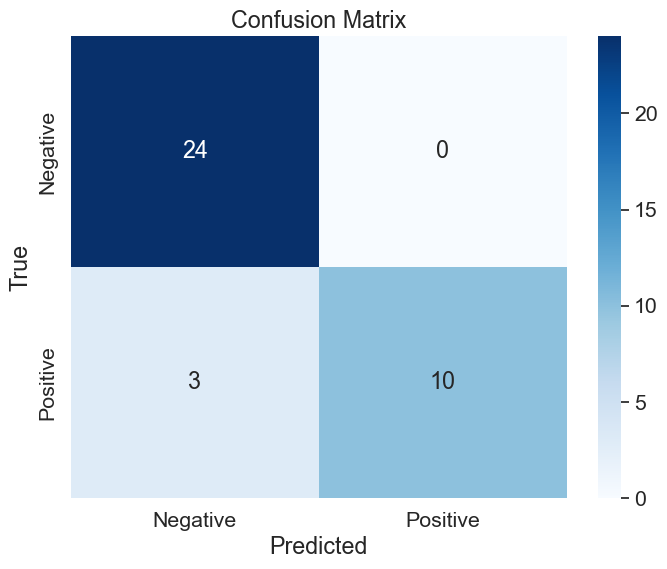

0:03:48.242097

Pred proft %: 1.005921682919435
Gamble proft %: 1.00587165012129
True proft %: 1.0619003945446202

Look Back: 3 / Total Loss: 20408762.48840851 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03835    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.2358   ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.87674    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.009', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.25045   ', 'TruePrice: 38.75      ', 'GambleProft: 1.004', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.89008    ', 'TruePrice: 1.923      ', 'GambleProft: 1.01 ', 'TrueProft: 1.028',

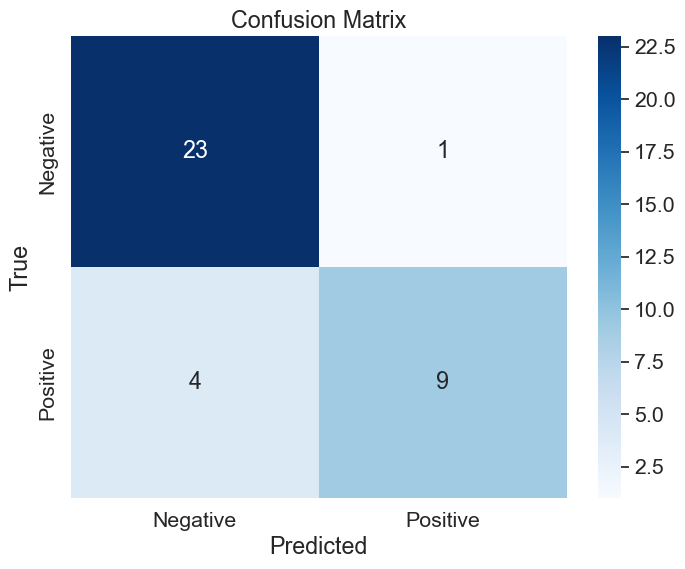

Wrong Buy_Act List:
DOGEBRL 

0:03:47.929984


In [29]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_1, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0067126937147923
Gamble proft %: 1.0070324728870133
True proft %: 1.0503948347619967

Look Back: 1 / Total Loss: 529372.8005036938 / Sold Portion: 0.8888888888888888 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03026    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99363    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.61743  ', 'TruePrice: 109.59     ', 'GambleProft: 1.008', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.11612    ', 'TruePrice: 6.194      ', 'GambleProft: 1.002', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.95193   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus

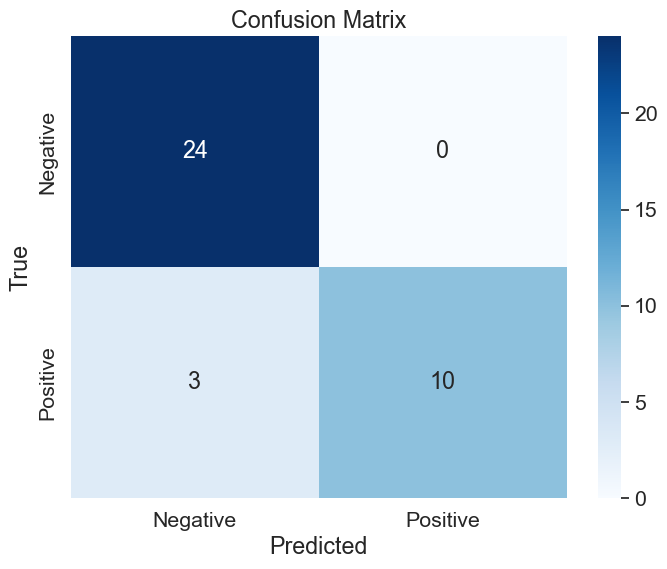

0:04:00.139550

Pred proft %: 1.005432744225926
Gamble proft %: 1.0054491919702957
True proft %: 1.0257540287327649

Look Back: 1 / Total Loss: 3579222.3373069093 / Sold Portion: 0.8888888888888888 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98777    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.17607    ', 'TruePrice: 6.194      ', 'GambleProft: 1.012', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.92403   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.63829   ', 'TruePrice: 38.75      ', 'GambleProft: 1.014', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.61184   ', 'TruePrice: 19.78      ', 'GambleProft: 1.005', 'TrueProft: 1.0

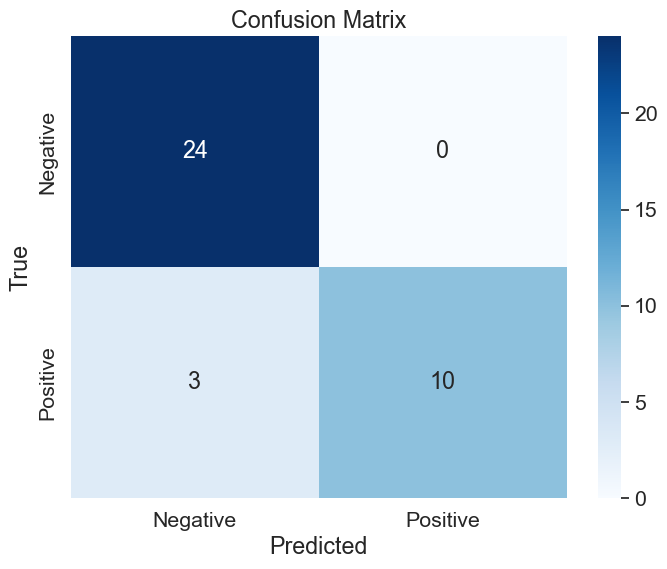

0:04:01.850539

Pred proft %: 1.0059150265790393
Gamble proft %: 1.0062431208974203
True proft %: 1.0512633220871554

Look Back: 1 / Total Loss: 2508999.6569926366 / Sold Portion: 0.875 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.35502  ', 'TruePrice: 109.59     ', 'GambleProft: 1.005', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.88335   ', 'TruePrice: 69.73      ', 'GambleProft: 1.001', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88027    ', 'TruePrice: 1.923      ', 'GambleProft: 1.005', 'TrueProft: 1.028', 'SoldSta

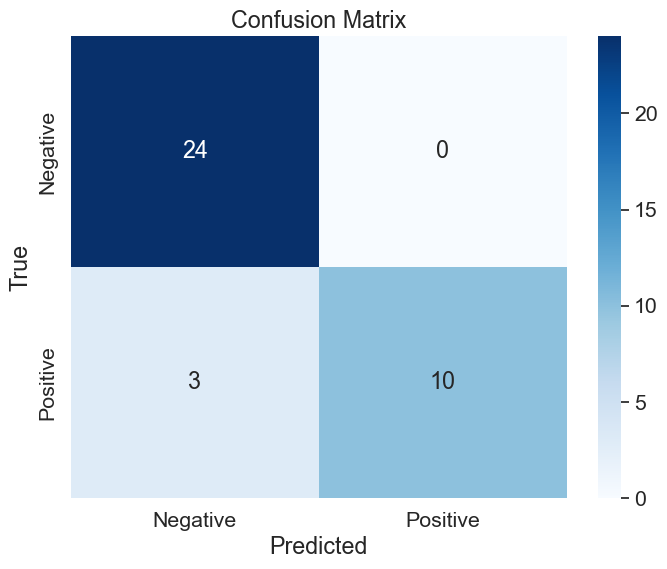

0:04:02.206411

Pred proft %: 1.002381396046925
Gamble proft %: 1.0015033077214395
True proft %: 1.0037802496976582

Look Back: 1 / Total Loss: 6613245.772458544 / Sold Portion: 0.7777777777777778 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2673.47058 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.00062    ', 'TruePrice: 4.977      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.10587  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.98769   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.78444   ', 'TruePrice: 19.78      ', 'GambleProft: 1.014', 'TrueProft: 1.01

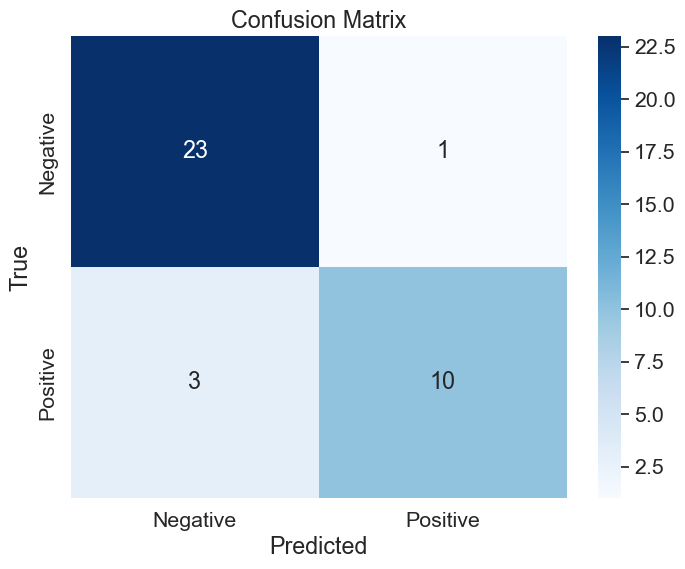

Wrong Buy_Act List:
BNBBRL 

0:03:59.713273

Pred proft %: 1.0081211494554063
Gamble proft %: 1.007153374059586
True proft %: 1.0004635884502473

Look Back: 1 / Total Loss: 10433962.167826552 / Sold Portion: 0.875 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03362    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2689.11654 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.007', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.91341   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.55338   ', 'TruePrice: 38.75      ', 'GambleProft: 1.012', 

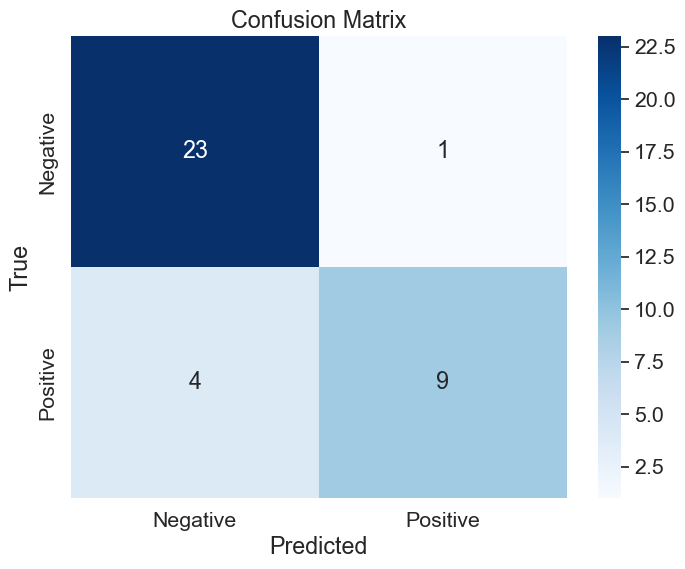

Wrong Buy_Act List:
BNBBRL 

0:04:01.882765

Pred proft %: 1.0053007043528048
Gamble proft %: 1.0053568295448103
True proft %: 1.0502348450583698

Look Back: 1 / Total Loss: 1161380.1082169071 / Sold Portion: 0.7272727272727273 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.01578    ', 'TruePrice: 4.977      ', 'GambleProft: 1.009', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.137    ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01463    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.01 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.16288    ', 'TruePrice: 6.194      ', 'GambleProft: 1.01 ', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.07779   ', 'TruePrice: 69.73      ', 'GambleP

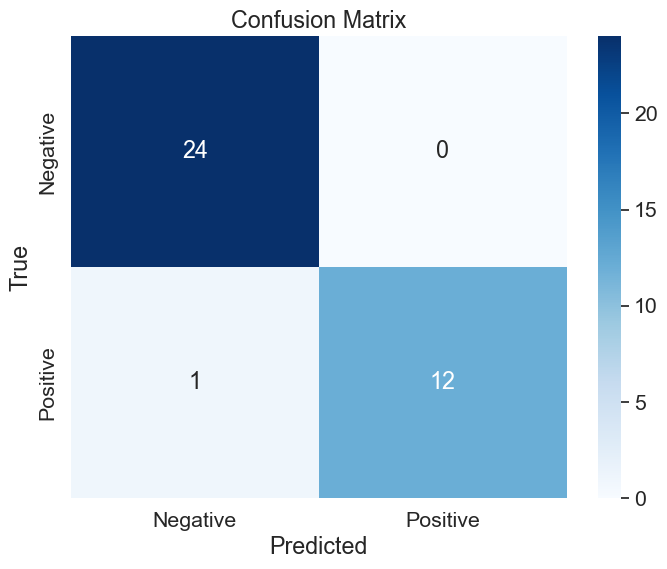

0:04:02.462181


MemoryError: Exception encountered when calling layer 'simple_rnn_cell' (type SimpleRNNCell).



Call arguments received by layer 'simple_rnn_cell' (type SimpleRNNCell):
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
  • states=('tf.Tensor(shape=(None, 11), dtype=float32)',)
  • training=None

In [37]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_2, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.01384363153592
Gamble proft %: 1.0127954141216386
True proft %: 1.0006509967311186

Look Back: 1 / Total Loss: 55412323.66875679 / Sold Portion: 0.75 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03585    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2704.7286  ', 'TruePrice: 2667.0     ', 'GambleProft: 1.013', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00019    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.136', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.28623   ', 'TruePrice: 69.73      ', 'GambleProft: 1.007', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectMo

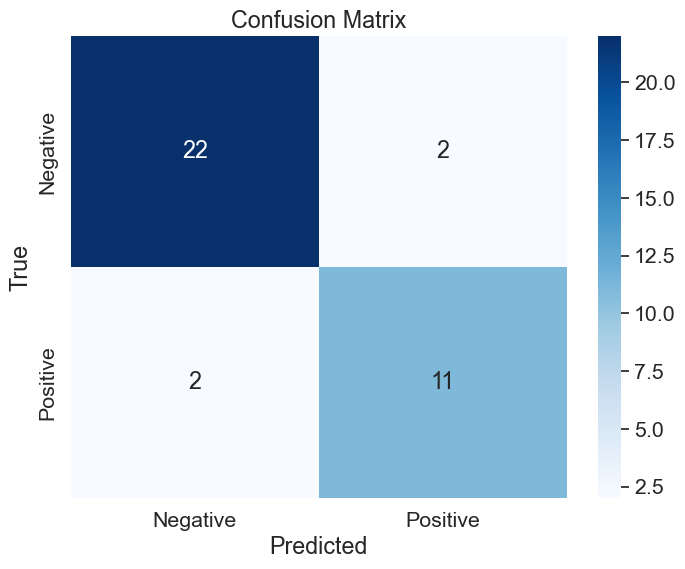

Wrong Buy_Act List:
BNBBRL 

SHIBBRL 

0:04:18.615140

Pred proft %: 1.0080474537319282
Gamble proft %: 1.0083690743981757
True proft %: 1.0511111911914996

Look Back: 1 / Total Loss: 53582735.6883441 / Sold Portion: 0.7 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.02964    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99156    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.14093  ', 'TruePrice: 109.59     ', 'GambleProft: 1.013', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.96265   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.32245   ', 'TruePrice: 38.75      ', 'GambleProft: 1

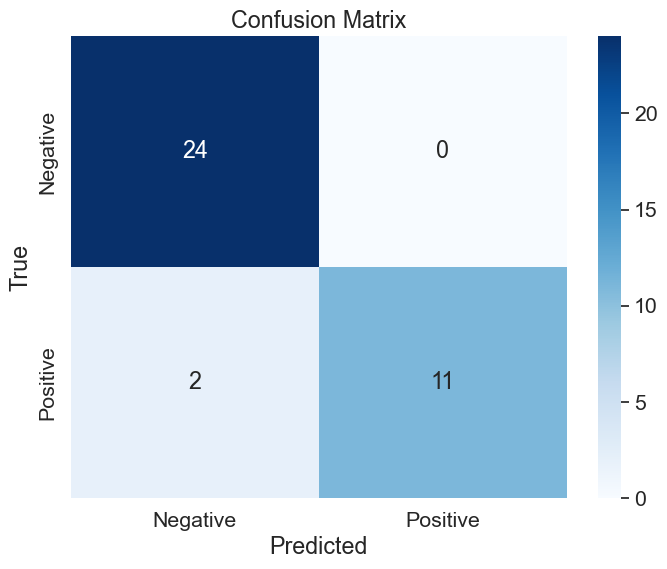

0:04:15.899290

Pred proft %: 1.004465936974347
Gamble proft %: 1.004871105438199
True proft %: 1.0505405014045492

Look Back: 1 / Total Loss: 66810464.71333543 / Sold Portion: 0.8571428571428571 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99298    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.20148  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94594   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.5325    ', 'TruePrice: 38.75      ', 'GambleProft: 1.011', 'TrueProft: 1.017'

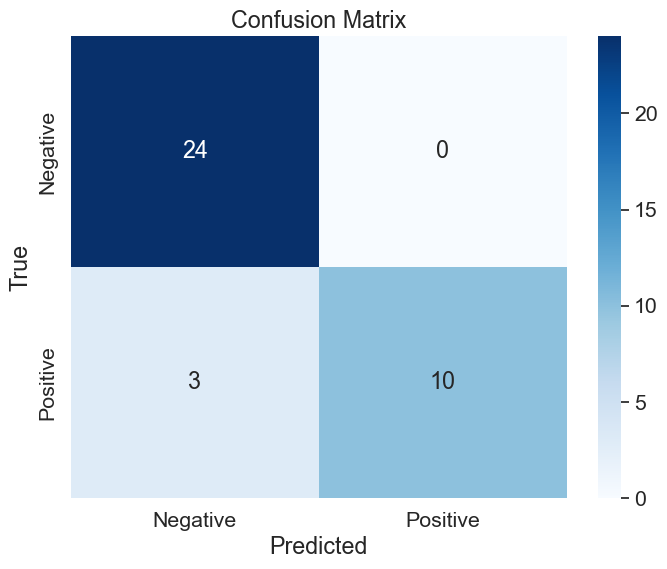

0:04:28.407982

Pred proft %: 1.0094909876362936
Gamble proft %: 1.0095349975327361
True proft %: 1.0261252275423045

Look Back: 1 / Total Loss: 64438077.66714876 / Sold Portion: 0.75 

['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.965     ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.35862   ', 'TruePrice: 38.75      ', 'GambleProft: 1.007', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.87938    ', 'TruePrice: 1.923      ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.88766   ', 'TruePrice: 19.78      ', 'GambleProft: 1.019', 'TrueProft: 1.014', 'SoldStat

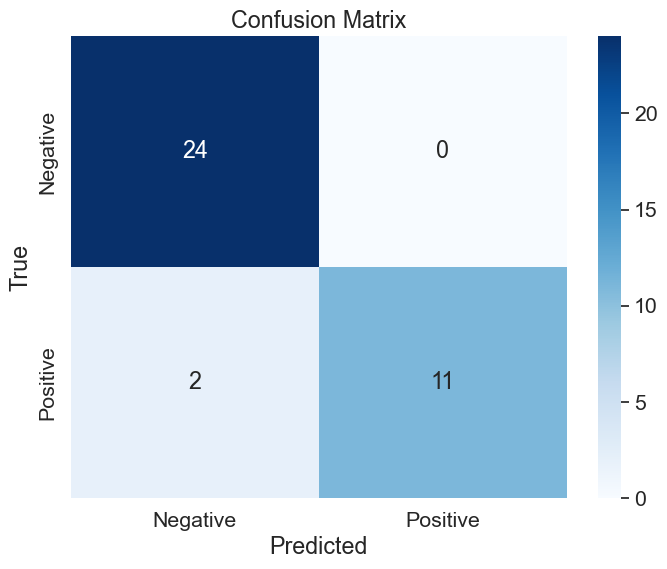

0:05:21.257605


In [15]:
for i in range(4):
    d = dt.datetime.now()
    pred_eval(model_2, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0155640652637548
Gamble proft %: 1.013145882469257
True proft %: 1.030312664923563

Look Back: 3 / Total Loss: 55309236.24575482 / Sold Portion: 0.8571428571428571 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.05009    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.11977    ', 'TruePrice: 6.194      ', 'GambleProft: 1.003', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.75383   ', 'TruePrice: 69.73      ', 'GambleProft: 1.014', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 

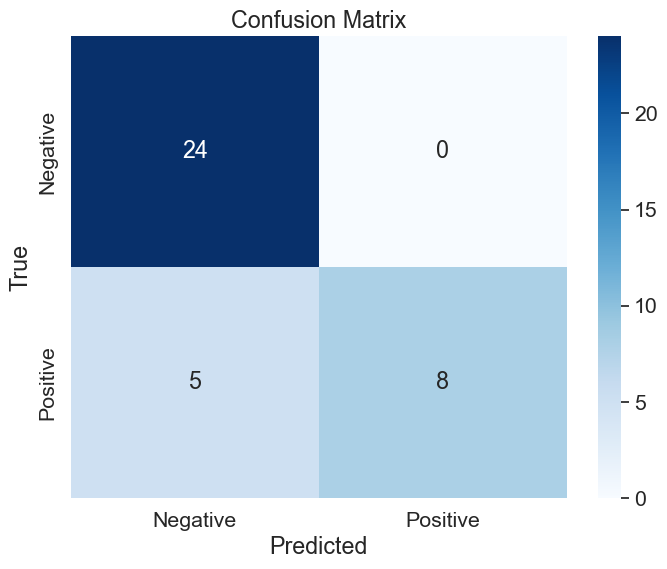

0:04:50.080333

Pred proft %: 1.0174414759545278
Gamble proft %: 1.017686497587153
True proft %: 1.0530634353164616

Look Back: 3 / Total Loss: 72834675.97522241 / Sold Portion: 0.375 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.05813    ', 'TruePrice: 5.041      ', 'GambleProft: 1.007', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.8368   ', 'TruePrice: 109.59     ', 'GambleProft: 1.02 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.88737    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.021', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.0146     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.008', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 39.36576   ', 'TruePrice: 38.75      ', 'GambleProft: 1.033', 'TrueProft: 1.017', 'SoldStatu

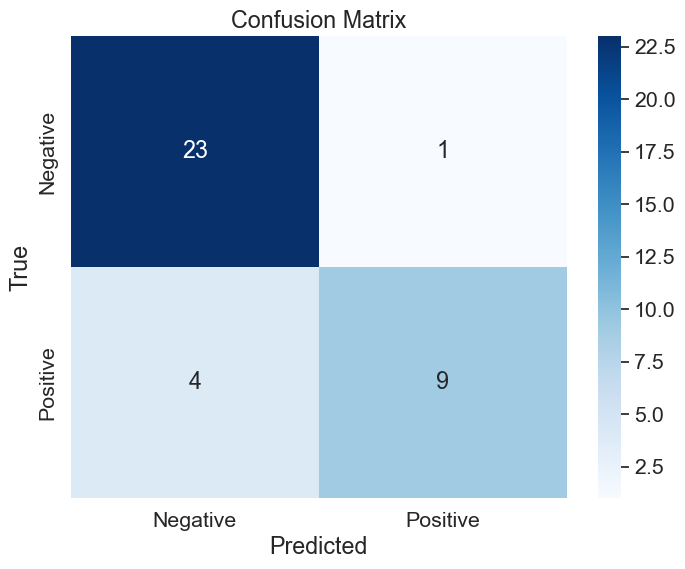

Wrong Buy_Act List:
DOGEBRL 

0:04:38.672661

Pred proft %: 1.0203679759017008
Gamble proft %: 1.020243406999955
True proft %: 1.0663994122580016

Look Back: 3 / Total Loss: 99806568.35888566 / Sold Portion: 0.5714285714285714 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04816    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.8368   ', 'TruePrice: 109.59     ', 'GambleProft: 1.02 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01474    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.018', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.9476     ', 'TruePrice: 1.923      ', 'GambleProft: 1.041', 'TrueProft: 1.028', 'SoldStatus: 0', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.34334    ', 'TruePrice: 1.337      ', 'GamblePr

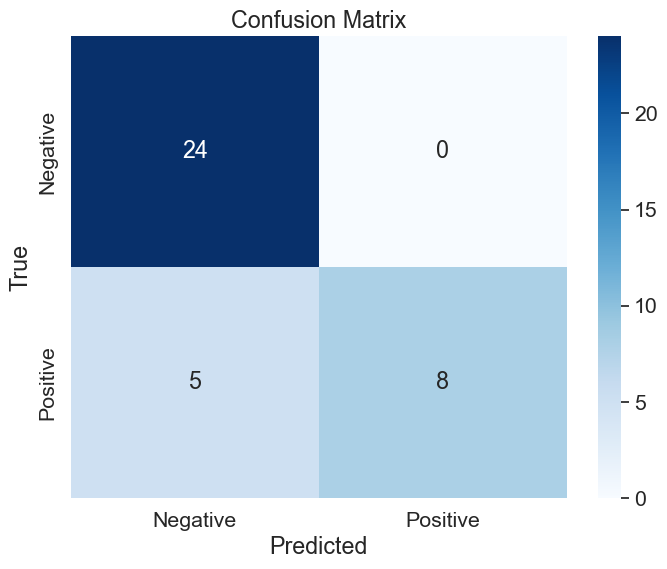

0:04:41.873559

Pred proft %: 1.0124049868750302
Gamble proft %: 1.0122108808285397
True proft %: 1.0530182479190853

Look Back: 3 / Total Loss: 71204478.79254338 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.05961    ', 'TruePrice: 5.041      ', 'GambleProft: 1.007', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97844    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.65888  ', 'TruePrice: 109.59     ', 'GambleProft: 1.008', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.13977    ', 'TruePrice: 6.194      ', 'GambleProft: 1.006', 'TrueProft: 1.01

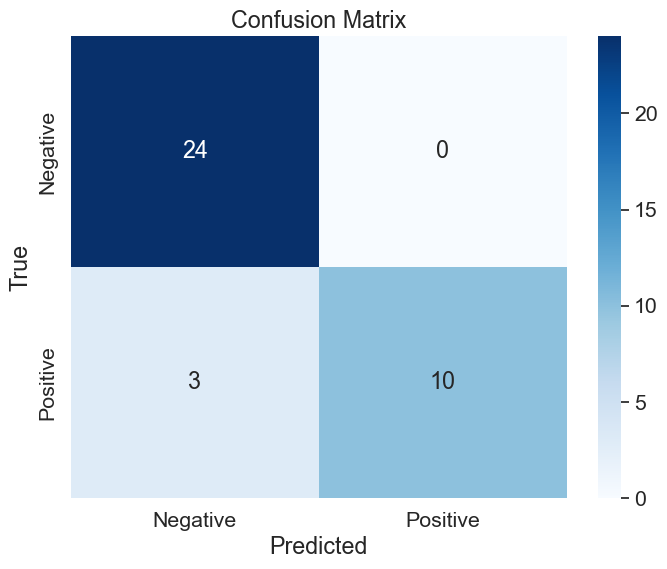

0:04:43.052739

Pred proft %: 1.0114126682207438
Gamble proft %: 1.0109487478755157
True proft %: 1.0284901704479277

Look Back: 3 / Total Loss: 71589729.7951345 / Sold Portion: 0.6363636363636364 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04517    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.88054    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.013', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['CHZBRL  ', 'LastPrice: 0.7659     ', 'MyGamble: 1.04574    ', 'TruePrice: 0.7561     ', 'GambleProft: 1.365', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.16764    ', 'TruePrice: 6.194      ', 'GambleProft: 1.011', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.36754   ', 'TruePrice: 69.73      ', 'GambleProft: 1.009', 'TrueProft: 1.044

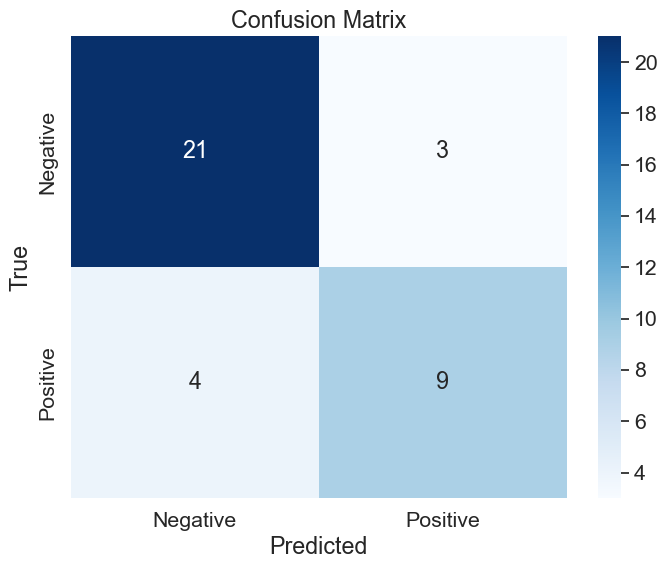

Wrong Buy_Act List:
DOGEBRL 

CHZBRL 

FISBRL 

0:04:57.009163

Pred proft %: 1.0077942703876979
Gamble proft %: 1.0075093668404886
True proft %: 1.0260026478601791

Look Back: 3 / Total Loss: 62900478.75526254 / Sold Portion: 0.5 

['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.87779    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.01 ', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.01978   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.77088   ', 'TruePrice: 19.78      ', 'GambleProft: 1.013', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.33974    ', 'TruePrice: 1.337      ', 'GambleProft: 1.017', 'TrueProft: 1.015', 'SoldStatus: 0', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.48406    ', 'TruePrice: 8.72       ', 'Gam

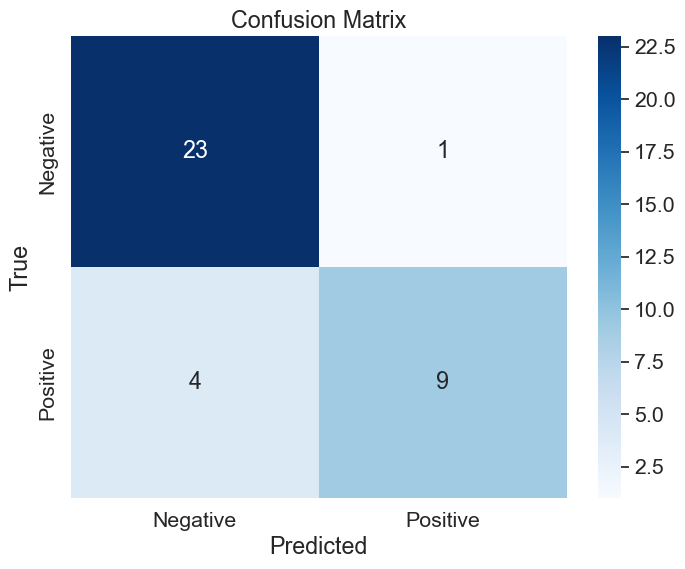

Wrong Buy_Act List:
DOGEBRL 

0:04:50.857920

Pred proft %: 1.0117500382093116
Gamble proft %: 1.011006905549616
True proft %: 1.0532337901039106

Look Back: 3 / Total Loss: 81663515.48574871 / Sold Portion: 0.8571428571428571 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03539    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.66153  ', 'TruePrice: 109.59     ', 'GambleProft: 1.008', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.8884     ', 'TruePrice: 1.923      ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.79643   ', 'TruePrice: 19.78      ', 'GambleP

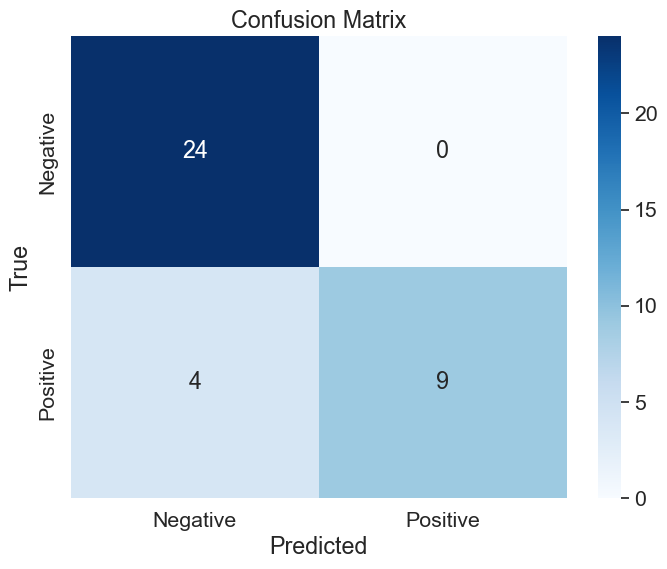

0:04:56.787187

Pred proft %: 1.008958494382576
Gamble proft %: 1.0088782051542886
True proft %: 1.0574947211179857

Look Back: 3 / Total Loss: 102664977.35497369 / Sold Portion: 0.5 

['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.88079    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.013', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.04051    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.01 ', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.89635   ', 'TruePrice: 69.73      ', 'GambleProft: 1.017', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.58657   ', 'TruePrice: 19.78      ', 'GambleProft: 1.004', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.45232    ', 'TruePrice: 8.72       ', 'GambleProft: 1.01 ', 'TrueProft: 1.042', 'SoldStatu

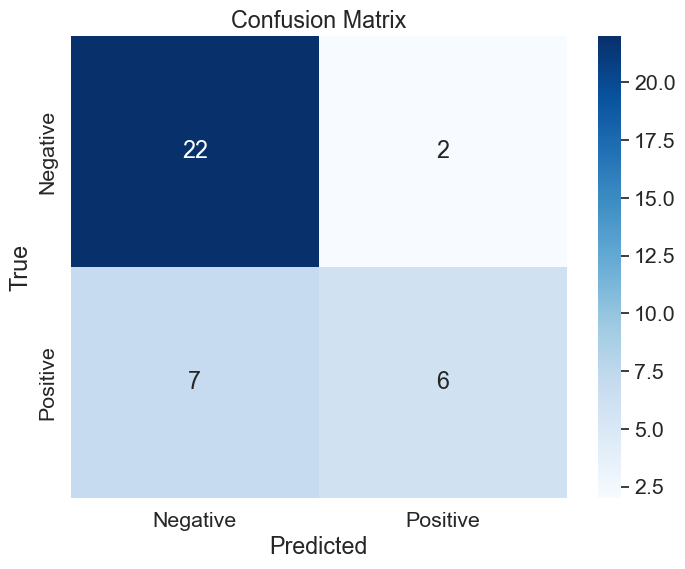

Wrong Buy_Act List:
DOGEBRL 

HOTBRL 

0:04:47.733335

Pred proft %: 1.018187428716501
Gamble proft %: 1.0163714833912623
True proft %: 1.0583403428271163

Look Back: 3 / Total Loss: 65353125.89574218 / Sold Portion: 0.8571428571428571 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03111    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.56563  ', 'TruePrice: 109.59     ', 'GambleProft: 1.017', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01457    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.006', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.95392   ', 'TruePrice: 69.73      ', 'GambleProft: 1.017', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 

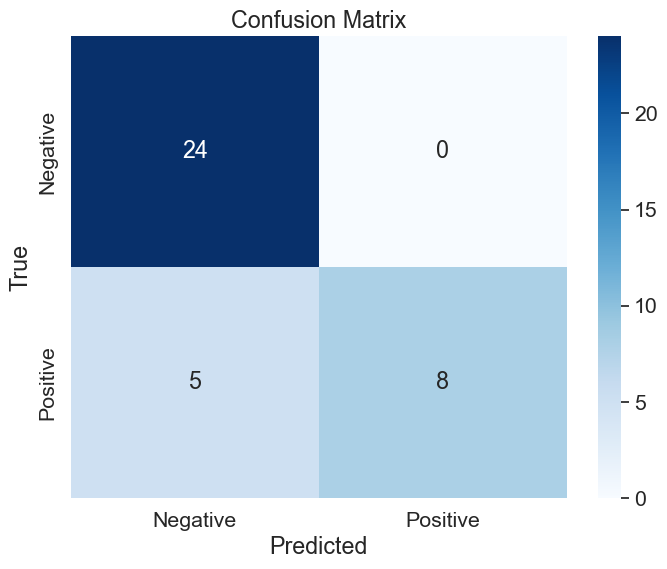

0:04:42.572962

Pred proft %: 1.0165383710054376
Gamble proft %: 1.01369000930962
True proft %: 1.0265506903732922

Look Back: 3 / Total Loss: 46755149.96938294 / Sold Portion: 0.7777777777777778 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04817    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.0432     ', 'TruePrice: 0.0386     ', 'GambleProft: 1.077', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.99312   ', 'TruePrice: 69.73      ', 'GambleProft: 1.018', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.89849    ', 'TruePrice: 1.923      ', 'GambleProft: 1.015', 'TrueProft: 1.028'

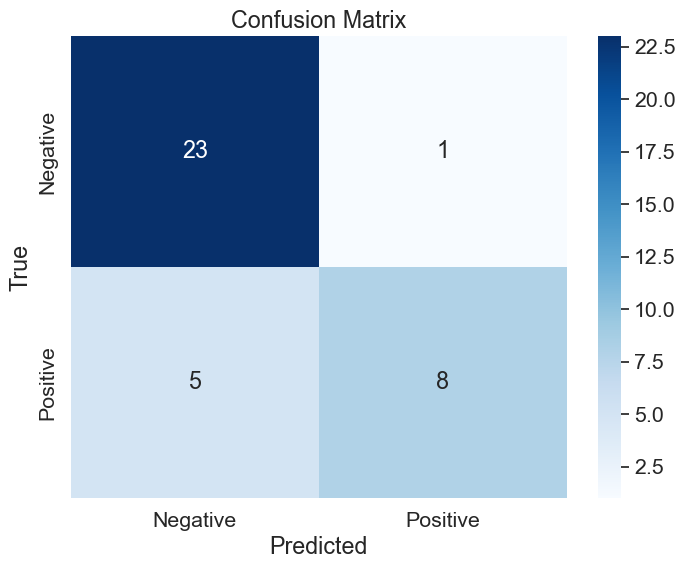

Wrong Buy_Act List:
HOTBRL 

0:04:42.826204


In [12]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_2, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0112054227706295
Gamble proft %: 1.0103231410165925
True proft %: 1.003894713150819

Look Back: 1 / Total Loss: 76786131.48173752 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2698.82972 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.011', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.56785  ', 'TruePrice: 109.59     ', 'GambleProft: 1.007', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.99869   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.5023    ', 'TruePrice: 38.75      ', 'GambleProft: 1.011', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.53625   ', 'TruePrice: 19.78      ', 'GambleProft: 1.001', 'TrueProft: 1.014', 'SoldStatus: 1', 'Correct

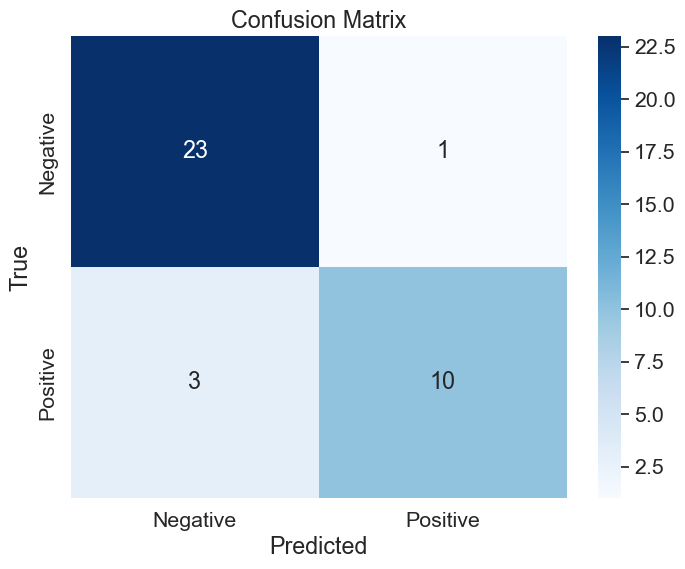

Wrong Buy_Act List:
BNBBRL 

0:05:08.157880

Pred proft %: 1.008051868474674
Gamble proft %: 1.00799951562657
True proft %: 1.025542209669078

Look Back: 1 / Total Loss: 131481513.09669581 / Sold Portion: 0.9090909090909091 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03624    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.99183    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01472    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.017', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.13357    ', 'TruePrice: 6.194      ', 'GambleProft: 1.005', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.08305   ', 'TruePrice: 69.73      ', 'GambleProft

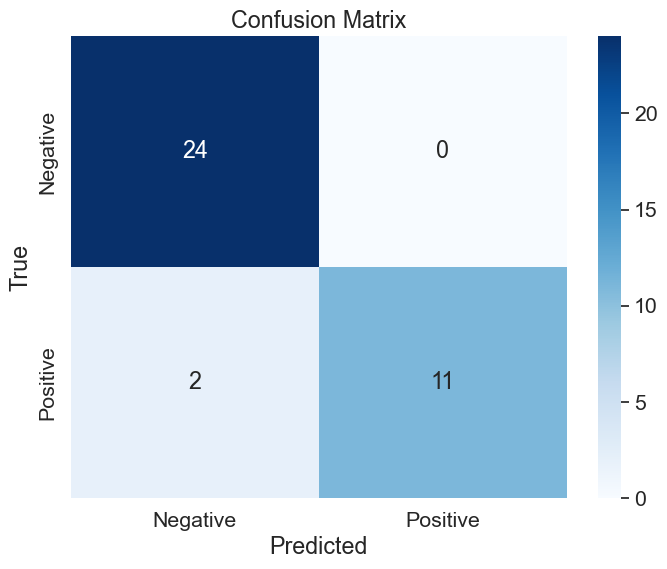

0:05:06.464956

Pred proft %: 1.0050987066806476
Gamble proft %: 1.0041725141379396
True proft %: 1.003917767603923

Look Back: 1 / Total Loss: 51532895.22807399 / Sold Portion: 0.8 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2681.41746 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.004', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98323    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.1321     ', 'TruePrice: 6.194      ', 'GambleProft: 1.005', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.95109   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus:

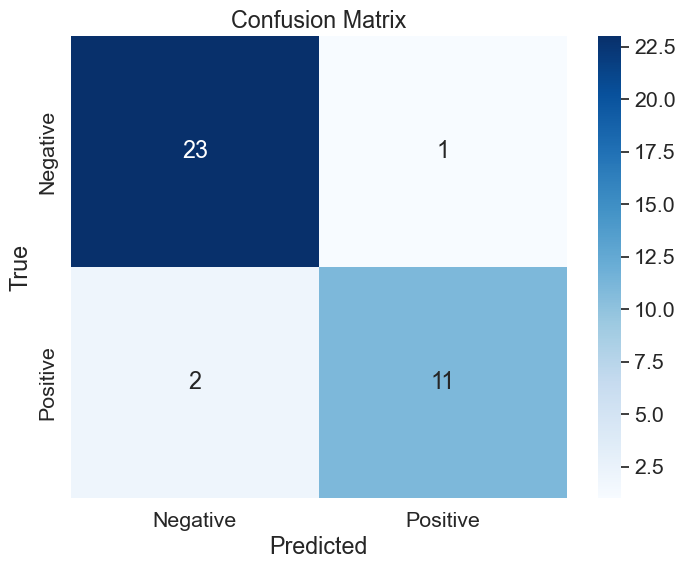

Wrong Buy_Act List:
BNBBRL 

0:05:09.477187

Pred proft %: 1.005285386673207
Gamble proft %: 1.0057298197917328
True proft %: 1.0515310277555276

Look Back: 1 / Total Loss: 77564393.70248155 / Sold Portion: 1.0 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.25969  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.0542    ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.70781   ', 'TruePrice: 38.75      ', 'GambleProft: 1.016', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.71964   ', 'TruePrice: 19.78      ', 'GambleProft: 1.011', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.3609     ', 'MyGamble: 0.36307    ', 'TruePrice: 0.4147     ', 'GambleProft: 1.006', 'T

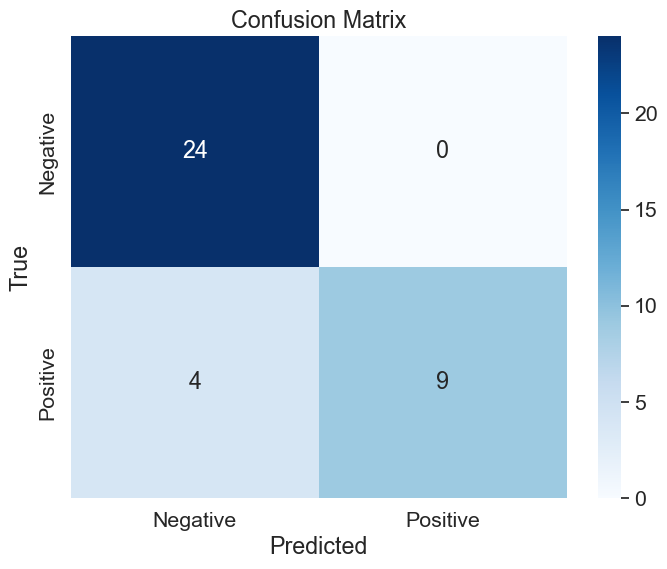

0:05:16.119744

Pred proft %: 1.0047404425684434
Gamble proft %: 1.0038290009871524
True proft %: 1.0039328490526285

Look Back: 1 / Total Loss: 74006597.4050675 / Sold Portion: 0.7272727272727273 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03194    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2679.2641  ', 'TruePrice: 2667.0     ', 'GambleProft: 1.003', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.79517  ', 'TruePrice: 109.59     ', 'GambleProft: 1.01 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.12267    ', 'TruePrice: 6.194      ', 'GambleProft: 1.003', 'TrueProft: 1.015

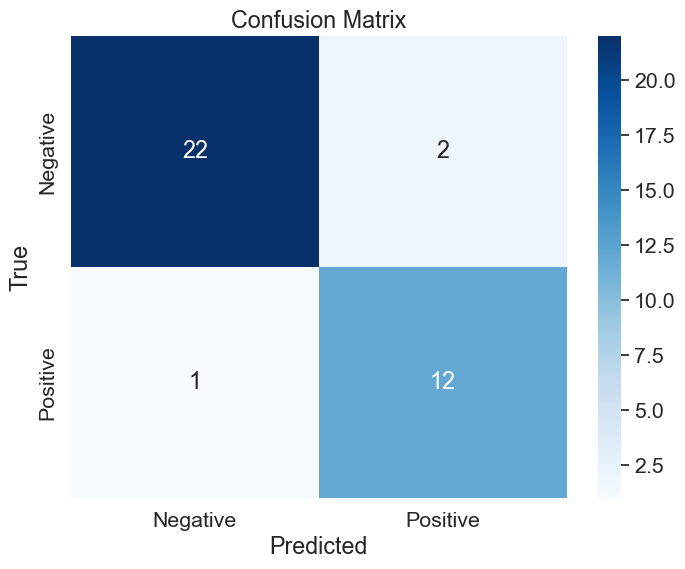

Wrong Buy_Act List:
BNBBRL 

SHIBBRL 

0:05:16.188501

Pred proft %: 1.003986420258169
Gamble proft %: 1.0039917646543874
True proft %: 1.0256134196042184

Look Back: 1 / Total Loss: 57468204.28950954 / Sold Portion: 1.0 

['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.12636    ', 'TruePrice: 6.194      ', 'GambleProft: 1.004', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.65173   ', 'TruePrice: 38.75      ', 'GambleProft: 1.014', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88165    ', 'TruePrice: 1.923      ', 'GambleProft: 1.006', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.47581    ', 'TruePrice: 8.72       ', 'GambleProft: 1.013', 'TrueProft: 1.042', 'SoldStatus: 1', 'CorrectModel: 1']
['APTBRL  ', 'LastPrice: 39.67      ', 'MyGamble: 39.73573   ', 'TruePrice: 40.17      ', 'GambleProft: 1

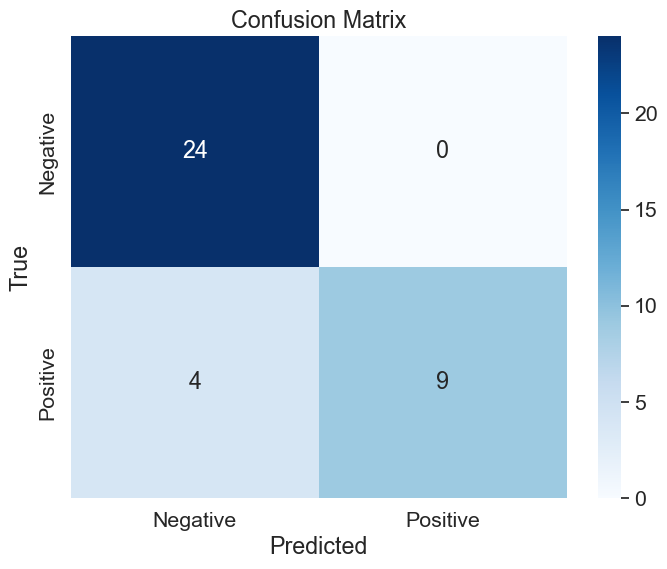

0:05:10.353885

Pred proft %: 1.0059062779868528
Gamble proft %: 1.0061378344159388
True proft %: 1.0502348450583698

Look Back: 1 / Total Loss: 69893670.7418401 / Sold Portion: 0.875 

['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.17076    ', 'TruePrice: 6.194      ', 'GambleProft: 1.011', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.14351   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.85423   ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90557    ', 'TruePrice: 1.923      ', 'GambleProft: 1.018', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.81574   ', 'TruePrice: 19.78      ', 'GambleProft: 1.016', 'TrueProft: 1.014', 'SoldStat

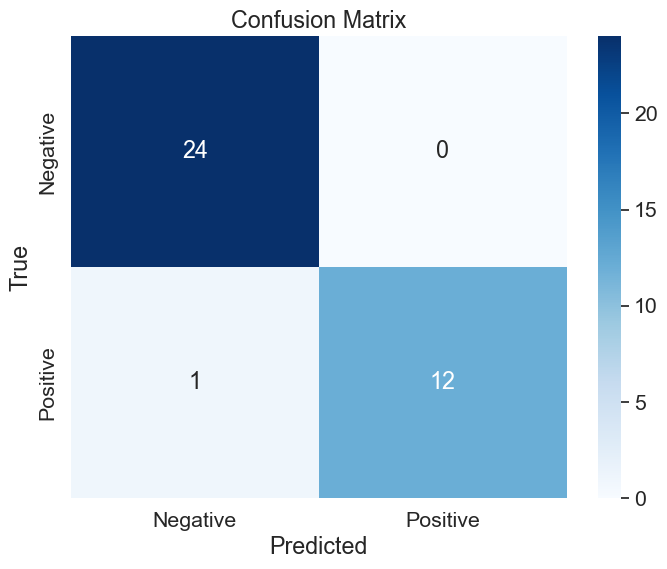

0:05:09.649833

Pred proft %: 1.0038907298419248
Gamble proft %: 1.0030182860506633
True proft %: 1.0038945798878112

Look Back: 1 / Total Loss: 93513784.74714746 / Sold Portion: 0.7777777777777778 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2676.33344 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97955    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.80086  ', 'TruePrice: 109.59     ', 'GambleProft: 1.01 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.1508    ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.7579    ', 'TruePrice: 38.75      ', 'GambleProft: 1.017', 'TrueProft: 1.01

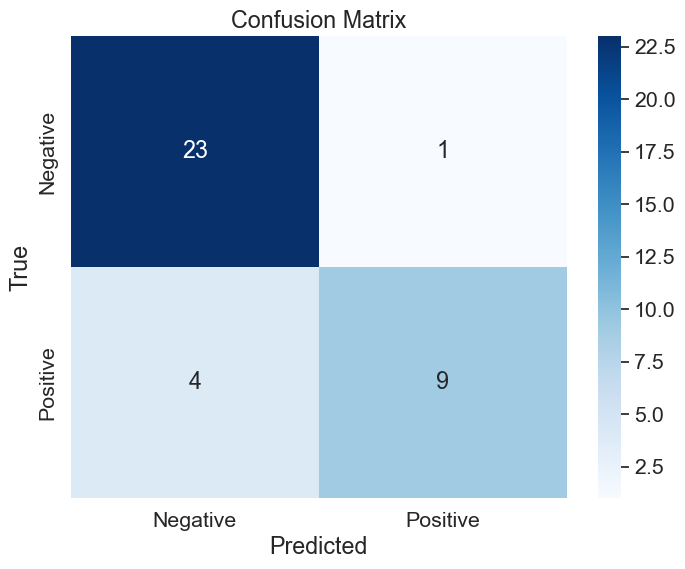

Wrong Buy_Act List:
BNBBRL 

0:05:09.031132

Pred proft %: 1.0043038895961898
Gamble proft %: 1.0034484997607969
True proft %: 1.0039127403266963

Look Back: 1 / Total Loss: 468451321.52998877 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2678.1251  ', 'TruePrice: 2667.0     ', 'GambleProft: 1.003', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.82646  ', 'TruePrice: 109.59     ', 'GambleProft: 1.01 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01468    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.014', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00104    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.054', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.92278   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 

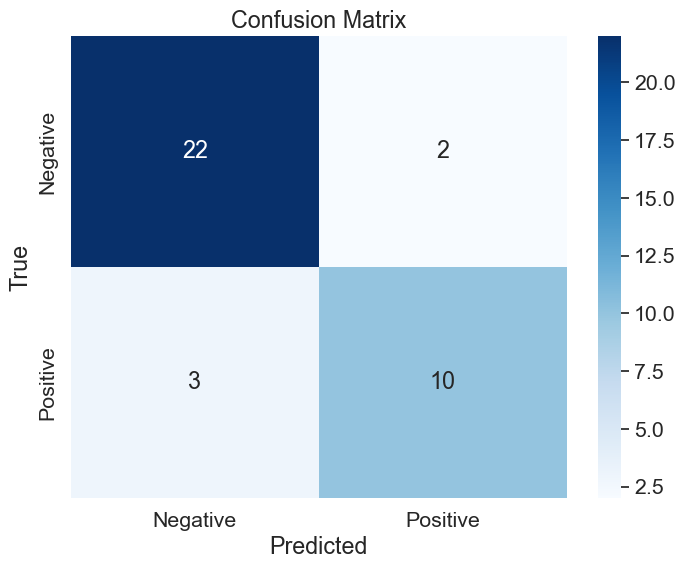

Wrong Buy_Act List:
BNBBRL 

WINBRL 

0:05:10.064604

Pred proft %: 1.037827736661738
Gamble proft %: 1.0377458712615522
True proft %: 1.0251151875204911

Look Back: 1 / Total Loss: 55550854.301573224 / Sold Portion: 0.7777777777777778 

['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01451    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.002', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.11244    ', 'TruePrice: 6.194      ', 'GambleProft: 1.002', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00018    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.067', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94019   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.46566   ', 'TruePrice: 38.75      ', 

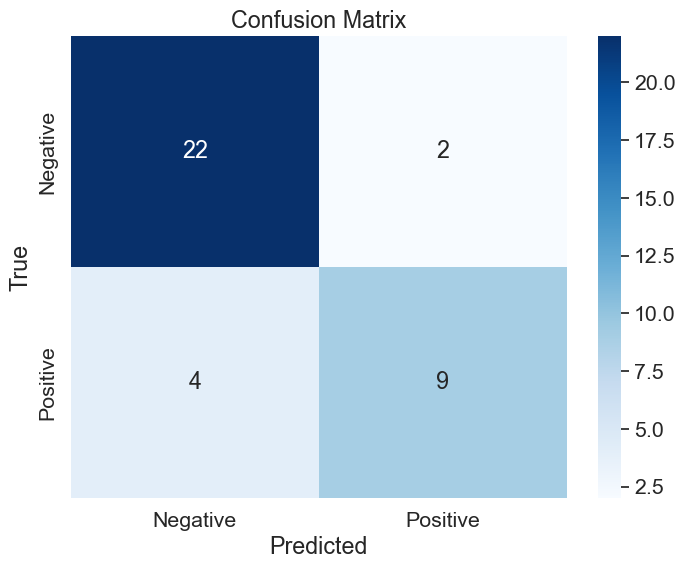

Wrong Buy_Act List:
SHIBBRL 

SANDBRL 

0:05:10.225725


In [13]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_3, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0080943056399434
Gamble proft %: 1.0072071538284026
True proft %: 1.0588125414009324

Look Back: 3 / Total Loss: 43910595.13100374 / Sold Portion: 0.625 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.12629    ', 'TruePrice: 5.041      ', 'GambleProft: 1.02 ', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00149    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.508', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.48575   ', 'TruePrice: 69.73      ', 'GambleProft: 1.01 ', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90842    ', 'TruePrice: 1.923      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.3609     ', 'MyGamble: 0.36812    ', 'TruePrice: 0.4147     ', 'GambleProft: 1.02 ', 'TrueProft: 1.149', 'SoldStatus: 1', 'Correc

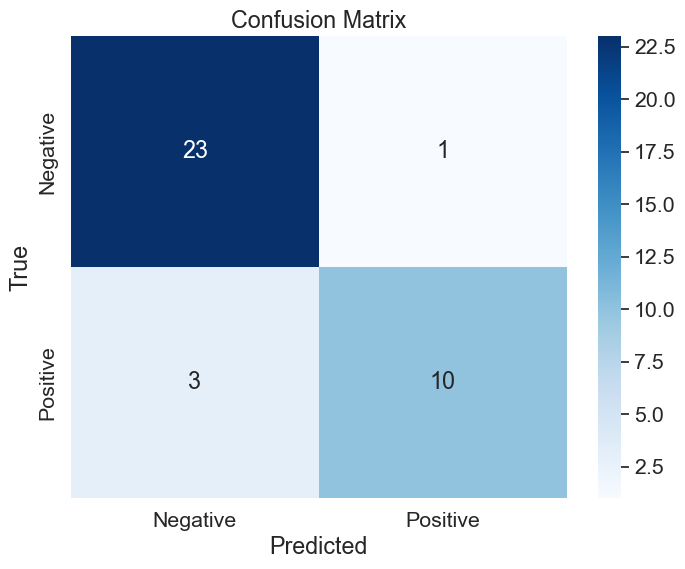

Wrong Buy_Act List:
WINBRL 

0:06:26.355458

Pred proft %: 1.0102530802960876
Gamble proft %: 1.009649271453789
True proft %: 1.0140479349821747

Look Back: 3 / Total Loss: 38377272.109396726 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.07249    ', 'TruePrice: 5.041      ', 'GambleProft: 1.01 ', 'TrueProft: 1.003', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.07363  ', 'TruePrice: 109.59     ', 'GambleProft: 1.012', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.5      ', 'MyGamble: 447.68779  ', 'TruePrice: 440.1      ', 'GambleProft: 1.007', 'TrueProft: 0.99 ', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.69581   ', 'TruePrice: 69.73      ', 'GambleProft: 1.014', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 39.12162   ', 'TruePrice: 38.75      ', 'GambleProft: 1.027', 'T

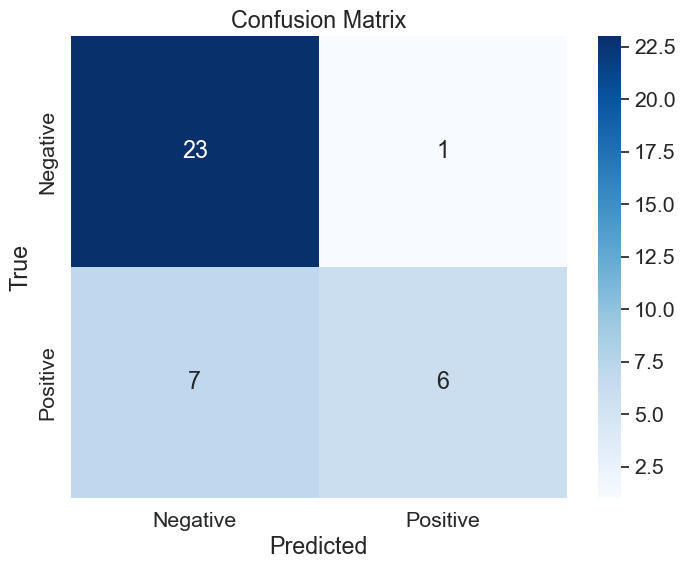

Wrong Buy_Act List:
LTCBRL 

0:06:29.572078

Pred proft %: 1.0097239673379734
Gamble proft %: 1.0087485080845975
True proft %: 1.0040317178292208

Look Back: 3 / Total Loss: 54871962.45823921 / Sold Portion: 0.5 

['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.9002    ', 'TruePrice: 19.78      ', 'GambleProft: 1.02 ', 'TrueProft: 1.014', 'SoldStatus: 0', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.3609     ', 'MyGamble: 0.36812    ', 'TruePrice: 0.4147     ', 'GambleProft: 1.02 ', 'TrueProft: 1.149', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.45523    ', 'TruePrice: 8.72       ', 'GambleProft: 1.01 ', 'TrueProft: 1.042', 'SoldStatus: 1', 'CorrectModel: 1']
['APTBRL  ', 'LastPrice: 39.67      ', 'MyGamble: 40.45524   ', 'TruePrice: 40.17      ', 'GambleProft: 1.02 ', 'TrueProft: 1.013', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.7837837837837838


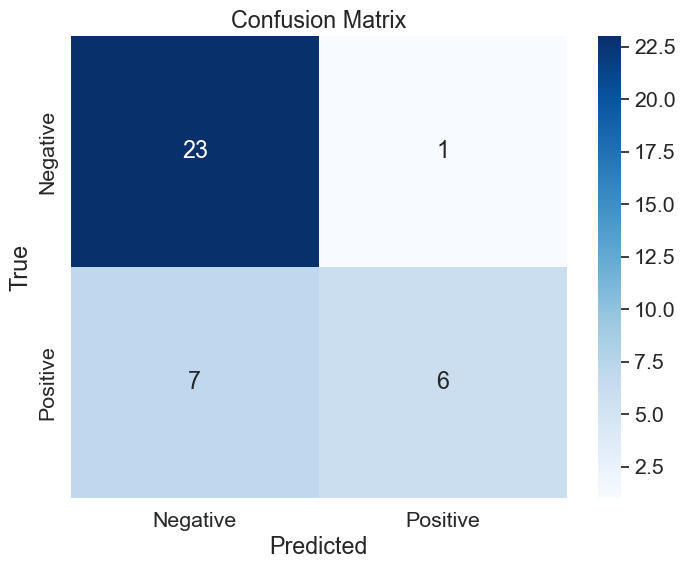

Wrong Buy_Act List:
ATOMBRL 

0:06:33.292890

Pred proft %: 1.0148857284546309
Gamble proft %: 1.0143814553119743
True proft %: 1.070136705503113

Look Back: 3 / Total Loss: 59013642.790705815 / Sold Portion: 0.4 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.8368   ', 'TruePrice: 109.59     ', 'GambleProft: 1.02 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.88444    ', 'TruePrice: 0.8569     ', 'GambleProft: 1.018', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00022    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.296', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.34334    ', 'TruePrice: 1.337      ', 'GambleProft: 1.02 ', 'TrueProft: 1.015', 'SoldStatus: 0', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.5374     ', 'TruePrice: 8.72       ', 'GambleProft: 1.02 ', '

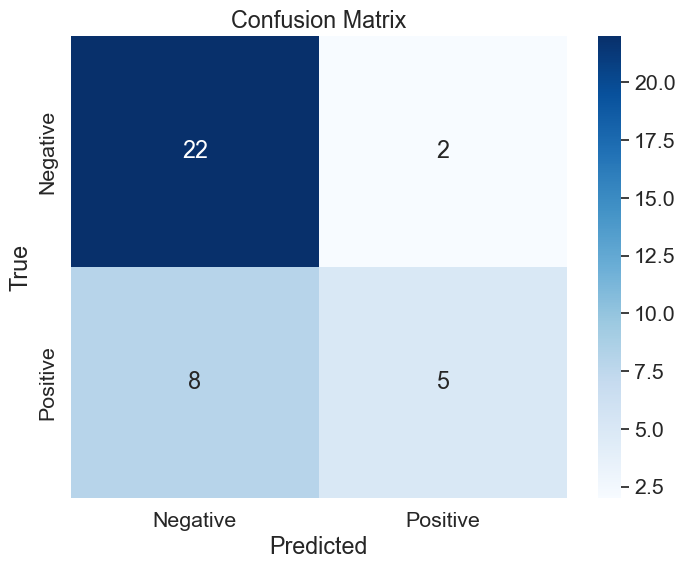

Wrong Buy_Act List:
DOGEBRL 

SHIBBRL 

0:06:47.469743

Pred proft %: 1.006014409007923
Gamble proft %: 1.006541407878968
True proft %: 1.0596962095778777

Look Back: 3 / Total Loss: 45745879.944334984 / Sold Portion: 0.8 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03288    ', 'TruePrice: 5.041      ', 'GambleProft: 1.002', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8692     ', 'MyGamble: 0.8793     ', 'TruePrice: 0.8569     ', 'GambleProft: 1.012', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.71552   ', 'TruePrice: 69.73      ', 'GambleProft: 1.014', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.62108   ', 'TruePrice: 38.75      ', 'GambleProft: 1.014', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.418      ', 'TruePrice: 8.72       ', 'GambleProft: 

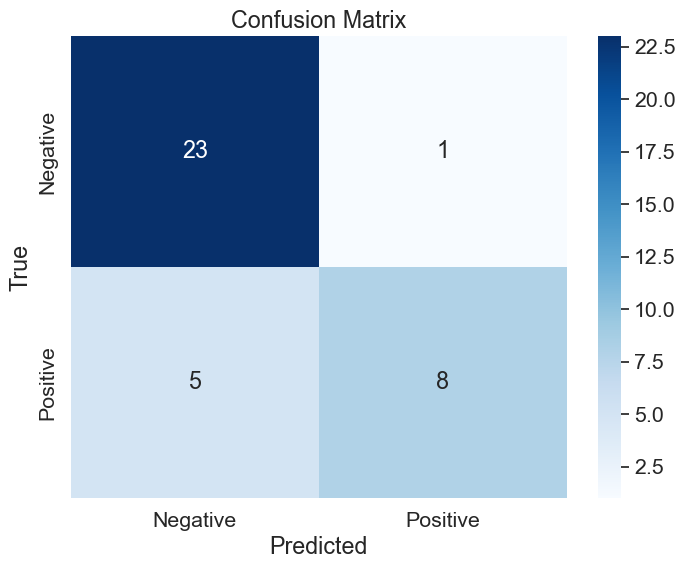

Wrong Buy_Act List:
DOGEBRL 

0:06:41.687541

Pred proft %: 1.0215983762089222
Gamble proft %: 1.0207793191385968
True proft %: 1.0007772785198383

Look Back: 3 / Total Loss: 54527026.53441836 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03821    ', 'TruePrice: 5.041      ', 'GambleProft: 1.003', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0401     ', 'MyGamble: 0.04026    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.004', 'TrueProft: 0.963', 'SoldStatus: 0', 'CorrectModel: 0']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.87917    ', 'TruePrice: 1.923      ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.87906   ', 'TruePrice: 19.78      ', 'GambleProft: 1.019', 'TrueProft: 1.014', 'SoldStatus: 0', 'CorrectModel: 1']
['ATOMBRL ', 'LastPrice: 67.64      ', 'MyGamble: 69.30123   ', 'TruePrice: 67.03      ', 'GambleProft: 1.025', 

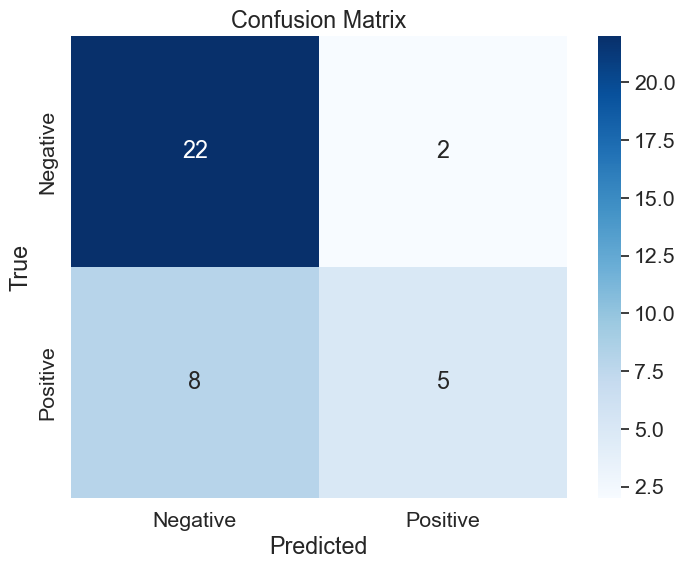

Wrong Buy_Act List:
HOTBRL 

ATOMBRL 

0:06:51.700216

Pred proft %: 1.0044756717973418
Gamble proft %: 1.004405241232036
True proft %: 1.0282861346424081

Look Back: 3 / Total Loss: 42517507.58765833 / Sold Portion: 0.75 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.0305     ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98755    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01465    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.012', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.21152    ', 'TruePrice: 6.194      ', 'GambleProft: 1.018', 'TrueProft: 1.015', 'SoldStatus: 0', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.86707   ', 'TruePrice: 69.73      ', 'GambleProft: 

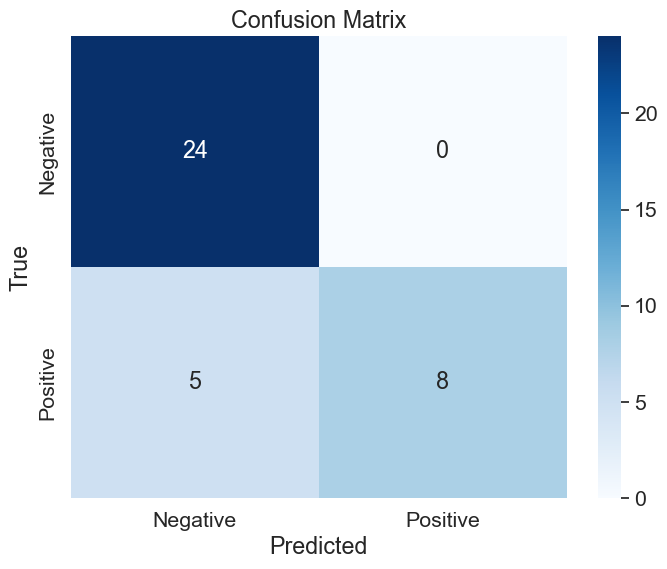

0:07:02.584963

Pred proft %: 1.0136153784917687
Gamble proft %: 1.013692928539386
True proft %: 1.0574061329408377

Look Back: 3 / Total Loss: 56520680.588104054 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04265    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.26833  ', 'TruePrice: 109.59     ', 'GambleProft: 1.014', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 68.20377   ', 'TruePrice: 69.73      ', 'GambleProft: 1.021', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.37147   ', 'TruePrice: 38.75      ', 'GambleProft: 1.007', 'TrueProft: 1.017', 'SoldStatus

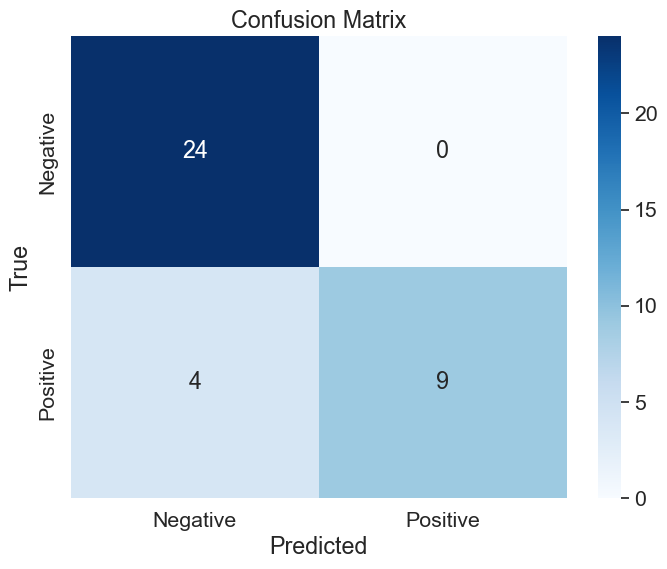

0:06:37.741407

Pred proft %: 1.0100473264753451
Gamble proft %: 1.008098940891051
True proft %: 1.0631001212571292

Look Back: 3 / Total Loss: 145547271.31375754 / Sold Portion: 0.6 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98888    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.75517  ', 'TruePrice: 109.59     ', 'GambleProft: 1.009', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.9002    ', 'TruePrice: 19.78      ', 'GambleProft: 1.02 ', 'TrueProft: 1.014', 'SoldStatus: 0', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.38347    ', 'TruePrice: 8.72       ', 'GambleProft: 1.002', 'TrueProft: 1.042', 'SoldStatus: 1', 'CorrectModel: 1']
['APTBRL  ', 'LastPrice: 39.67      ', 'MyGamble: 39.72923   ', 'TruePrice: 40.17      ', 'GambleProft: 1.001', 'TrueProft: 1.013', 'SoldStatu

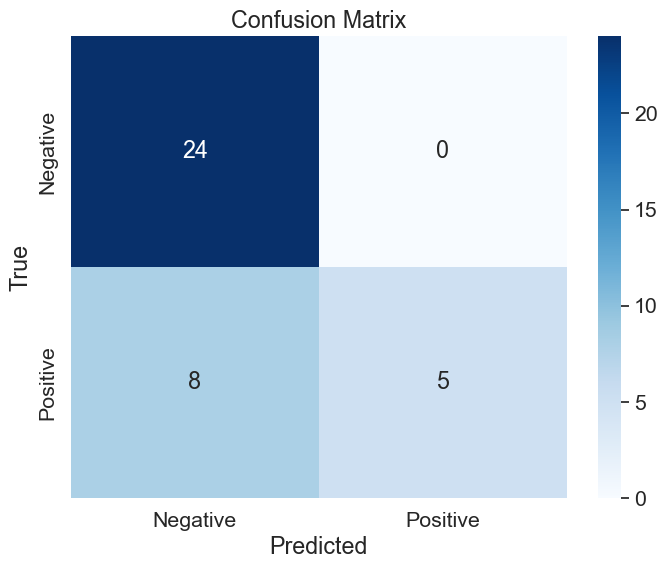

0:06:36.192459

Pred proft %: 1.0061404270499286
Gamble proft %: 1.0066062032630594
True proft %: 1.0577222896904848

Look Back: 3 / Total Loss: 75177498.90490219 / Sold Portion: 1.0 

['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.12033    ', 'TruePrice: 6.194      ', 'GambleProft: 1.003', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.55056   ', 'TruePrice: 69.73      ', 'GambleProft: 1.011', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.779     ', 'TruePrice: 38.75      ', 'GambleProft: 1.018', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.51924    ', 'TruePrice: 8.72       ', 'GambleProft: 1.018', 'TrueProft: 1.042', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.8378378378378378


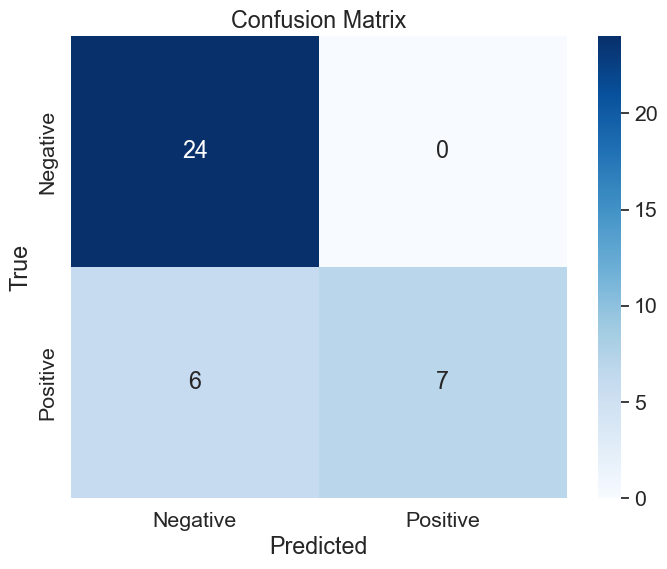

0:06:45.330143


In [14]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_3, epochs = 100, lb_list = [3], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)

In [ ]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_3, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
